# Notes

sampling methods
- simple random sampling
- stratified random sampling
- cluster sampling
- systematic sampling
- convenience sampling
- judgement sampling

Hypothesis testing
- null and alternative
- reject null -> type I error (alpha)
- accept null -> type II error (beta)
- random sample / matched sample
- test of independence

ANOVA
- comparing means
- bonferroni correction and other techniques for correcting error rates
- randomized block design
- 2-factor design

Linear regression
- 5 assumptions of linear regression
- significance: t test and F test
    - caution: no casual relationship / extrapolation
- residuals plots
- check for outlier and influential observation
    - remove to see impact
    - leverage and cook's distance
- check for multicollinearity

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import seaborn as sns
import plotly.express as px
import re
from matplotlib.colors import TwoSlopeNorm
import missingno as msno
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import math
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import itertools
from collections.abc import Iterable
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
import pmdarima as pm
import warnings
from statsmodels.tools.sm_exceptions import ModelWarning
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics import tsaplots
import datetime
from tqdm import tqdm

from linear_reg_diagnostics import Linear_Reg_Diagnostics # custom module

In [2]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pd.set_option('display.max_columns', None)

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [4]:
# Projected Coordinate System: how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System: how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import data

## Neighbourhood population

In [5]:
neighbourhoods = gpd.read_file('../data/processed/neighbourhoods.geojson', driver='GeoJSON')
neighbourhoods_population = neighbourhoods[['hood_id', 'district', 'occurrence_year', 'population']].copy()
neighbourhoods_population['hood_id'] = neighbourhoods_population['hood_id'].astype(str)
neighbourhoods_population

hood_id district  occurrence_year    population
0          1      W10             2014  34745.000000
1          1      W10             2015  34557.000000
2          1      W10             2016  34418.000000
3          1      W10             2017  35085.000000
4          1      W10             2018  35773.000000
...      ...      ...              ...           ...
1115      99      C10             2017  17448.000000
1116      99      C10             2018  17633.000000
1117      99      C10             2019  17812.000000
1118      99      C10             2020  17972.000000
1119      99      C10             2021  18133.437233

[1120 rows x 4 columns]

## Distance from University of Toronto

In [6]:
distance_df = neighbourhoods[['hood_id', 'distance_km']].drop_duplicates()
distance_df['hood_id'] = distance_df['hood_id'].astype(str)
distance_df

hood_id  distance_km
0          1    17.218654
8         10    12.000046
16       100     4.698206
24       101     3.829475
32       102     5.290025
...      ...          ...
1080      95     1.180349
1088      96     2.335999
1096      97     2.791462
1104      98     2.579735
1112      99     4.756160

[140 rows x 2 columns]

## Crime rate

In [7]:
mci_df = pd.read_csv('../data/processed/neighbourhoods_crime.csv')
mci_df = mci_df[(mci_df['MCI'] == 'MCI') & (mci_df['type'] == 'rate')]
mci_df.rename(columns={'value': 'MCI_rate'}, inplace=True)
mci_df['occurrence_date'] = pd.PeriodIndex(year=mci_df['occurrence_year'], quarter=mci_df['occurrence_quarter']).end_time.date
mci_df = mci_df[['occurrence_date', 'occurrence_year', 'occurrence_quarter', 'hood_id', 'MCI_rate']]
mci_df['hood_id'] = mci_df['hood_id'].astype(str)
mci_df

occurrence_date  occurrence_year  occurrence_quarter hood_id    MCI_rate
35868      2014-03-31             2014                   1       1  549.719384
35869      2014-06-30             2014                   2       1  754.065333
35870      2014-09-30             2014                   3       1  592.891063
35871      2014-12-31             2014                   4       1  656.209527
35900      2015-03-31             2015                   1       1  460.109384
...               ...              ...                 ...     ...         ...
71647      2020-12-31             2020                   4      99  133.541064
71676      2021-03-31             2021                   1      99  121.322834
71677      2021-06-30             2021                   2      99  220.586971
71678      2021-09-30             2021                   3      99  170.954903
71679      2021-12-31             2021                   4      99  187.498926

[4480 rows x 5 columns]

## Traffic collisions

In [8]:
collision_df = pd.read_csv('../data/processed/neighbourhoods_collision.csv')
collision_df = collision_df[(collision_df['collision_type'] == 'collision') & (collision_df['type'] == 'rate')]
collision_df.rename(columns={'value': 'collision_rate'}, inplace=True)
collision_df['occurrence_date'] = pd.PeriodIndex(year=collision_df['occurrence_year'], quarter=collision_df['occurrence_quarter']).end_time.date
collision_df = collision_df[['occurrence_date', 'occurrence_year', 'occurrence_quarter', 'hood_id', 'collision_rate']]
collision_df['hood_id'] = collision_df['hood_id'].astype(str)
collision_df

occurrence_date  occurrence_year  occurrence_quarter hood_id  \
22400      2014-03-31             2014                   1       1   
22401      2014-06-30             2014                   2       1   
22402      2014-09-30             2014                   3       1   
22403      2014-12-31             2014                   4       1   
22420      2015-03-31             2015                   1       1   
...               ...              ...                 ...     ...   
44763      2020-12-31             2020                   4      99   
44780      2021-03-31             2021                   1      99   
44781      2021-06-30             2021                   2      99   
44782      2021-09-30             2021                   3      99   
44783      2021-12-31             2021                   4      99   

       collision_rate  
22400     1013.095409  
22401      863.433588  
22402      912.361491  
22403      897.970931  
22420      966.519084  
...               ...  
44763      411.751614  
44780      297.792411  
44781      248.160343  
44782        0.000000  
44783        0.000000  

[4480 rows x 5 columns]

## Lease rate

In [9]:
neighbourhoods_rent = pd.read_csv('../data/processed/neighbourhoods_rent.csv')
neighbourhoods_rent.rename(columns={'Year': 'occurrence_year', 'Quarter': 'occurrence_quarter'}, inplace=True)
neighbourhoods_rent = neighbourhoods_rent[(neighbourhoods_rent['occurrence_year'] >= 2014) & 
                                          (neighbourhoods_rent['RoomType'] == 'SharedApartments')]
neighbourhoods_rent = neighbourhoods_population[['hood_id', 'district']].drop_duplicates().merge(neighbourhoods_rent, on = 'district')
neighbourhoods_rent['occurrence_date'] = pd.PeriodIndex(year=neighbourhoods_rent['occurrence_year'], quarter=neighbourhoods_rent['occurrence_quarter']).end_time.date
neighbourhoods_rent = neighbourhoods_rent[['occurrence_date', 'occurrence_year', 'occurrence_quarter', 'hood_id', 'LeasedvsListed_AllApartments', 'AvgLeaseRatePerRoom']]
neighbourhoods_rent['hood_id'] = neighbourhoods_rent['hood_id'].astype(str)
neighbourhoods_rent

occurrence_date  occurrence_year  occurrence_quarter hood_id  \
0         2014-03-31             2014                   1       1   
1         2014-06-30             2014                   2       1   
2         2014-09-30             2014                   3       1   
3         2014-12-31             2014                   4       1   
4         2015-03-31             2015                   1       1   
...              ...              ...                 ...     ...   
4475      2020-12-31             2020                   4      98   
4476      2021-03-31             2021                   1      98   
4477      2021-06-30             2021                   2      98   
4478      2021-09-30             2021                   3      98   
4479      2021-12-31             2021                   4      98   

      LeasedvsListed_AllApartments  AvgLeaseRatePerRoom  
0                         0.444444           661.647059  
1                         0.651163           703.361702  
2                         0.586957           715.241379  
3                         0.500000           667.428571  
4                         0.444444           691.555556  
...                            ...                  ...  
4475                      0.289474          1674.339623  
4476                      0.380000          1599.648649  
4477                      0.484848          1751.264706  
4478                      0.594340          1664.652174  
4479                      0.653333          1890.630769  

[4480 rows x 6 columns]

# Create regression_df

In [10]:
# neighbourhoods_rent = neighbourhoods_rent[['hood_id', 'All_Apartments_Leased_vs_Listed', 'All_Apartments_Avg_Lease_Rate_Per_Room', 'occurrence_date']]
# mci_df = mci_df[['hood_id', 'occurrence_date', 'MCI_Rate']]
# collision_df = collision_df[['hood_id', 'occurrence_date', 'Collision_Rate']]
regression_table = neighbourhoods_rent.\
    merge(mci_df, on=['hood_id', 'occurrence_date', 'occurrence_year', 'occurrence_quarter'], how='outer').\
    merge(collision_df, on=['hood_id', 'occurrence_date', 'occurrence_year', 'occurrence_quarter'], how='outer').\
    merge(distance_df, on=['hood_id'], how='outer')
regression_table.ffill(inplace=True)

In [11]:
Y = 'AvgLeaseRatePerRoom'
Xs = ['LeasedvsListed_AllApartments', 'MCI_rate', 'collision_rate', 'distance_km']
regression_table[['hood_id', 'occurrence_date'] + [Y] + Xs]

hood_id occurrence_date  AvgLeaseRatePerRoom  \
0          1      2014-03-31           661.647059   
1          1      2014-06-30           703.361702   
2          1      2014-09-30           715.241379   
3          1      2014-12-31           667.428571   
4          1      2015-03-31           691.555556   
...      ...             ...                  ...   
4475      98      2020-12-31          1674.339623   
4476      98      2021-03-31          1599.648649   
4477      98      2021-06-30          1751.264706   
4478      98      2021-09-30          1664.652174   
4479      98      2021-12-31          1890.630769   

      LeasedvsListed_AllApartments    MCI_rate  collision_rate  distance_km  
0                         0.444444  549.719384     1013.095409    17.218654  
1                         0.651163  754.065333      863.433588    17.218654  
2                         0.586957  592.891063      912.361491    17.218654  
3                         0.500000  656.209527      897.970931    17.218654  
4                         0.444444  460.109384      966.519084    17.218654  
...                            ...         ...             ...          ...  
4475                      0.289474  396.741654      261.680665     2.579735  
4476                      0.380000  321.624560      160.812280     2.579735  
4477                      0.484848  263.897075      193.799415     2.579735  
4478                      0.594340  321.624560        0.000000     2.579735  
4479                      0.653333  371.105262        0.000000     2.579735  

[4480 rows x 7 columns]

In [12]:
regression_df = regression_table[[Y] + Xs].copy()
regression_df['Time'] = regression_table['occurrence_year'] + regression_table['occurrence_quarter'] / 4
regression_df['Quarter'] = regression_table['occurrence_quarter']
regression_df['hood_id'] = regression_table['hood_id']
# regression_df = pd.concat([regression_df, 
#                            pd.get_dummies(pd.Series(['Q' + str(x) for x in regression_table['occurrencedate'].dt.quarter]), drop_first = True),
#                            pd.get_dummies(pd.Series(['N' + str(x) for x in regression_table['hood_id']]), drop_first = True)],
#                           axis=1)
regression_df.rename(columns={'AvgLeaseRatePerRoom': 'Rent',
                              'LeasedvsListed_AllApartments': 'Lease_Demand',
                              'MCI_rate': 'Crime',
                              'collision_rate': 'Traffic_Collisions',
                              'distance_km': 'Distance'}, inplace=True)
regression_df

Rent  Lease_Demand       Crime  Traffic_Collisions   Distance  \
0      661.647059      0.444444  549.719384         1013.095409  17.218654   
1      703.361702      0.651163  754.065333          863.433588  17.218654   
2      715.241379      0.586957  592.891063          912.361491  17.218654   
3      667.428571      0.500000  656.209527          897.970931  17.218654   
4      691.555556      0.444444  460.109384          966.519084  17.218654   
...           ...           ...         ...                 ...        ...   
4475  1674.339623      0.289474  396.741654          261.680665   2.579735   
4476  1599.648649      0.380000  321.624560          160.812280   2.579735   
4477  1751.264706      0.484848  263.897075          193.799415   2.579735   
4478  1664.652174      0.594340  321.624560            0.000000   2.579735   
4479  1890.630769      0.653333  371.105262            0.000000   2.579735   

         Time  Quarter hood_id  
0     2014.25        1       1  
1     2014.50        2       1  
2     2014.75        3       1  
3     2015.00        4       1  
4     2015.25        1       1  
...       ...      ...     ...  
4475  2021.00        4      98  
4476  2021.25        1      98  
4477  2021.50        2      98  
4478  2021.75        3      98  
4479  2022.00        4      98  

[4480 rows x 8 columns]

In [13]:
# time = ['Time']
# quarters = [re.search('Q\d+', x).group(0) for x in regression_df.columns if re.search('Q\d+', x) is not None]
# neighbourhood_id = [re.search('N\d+', x).group(0) for x in regression_df.columns if re.search('N\d+', x) is not None]

Y = 'Rent'
Xs_numeric = ['Lease_Demand', 'Crime', 'Traffic_Collisions', 'Distance']
# Xs = Xs_numeric + time + quarters + neighbourhood_id
Xs = Xs_numeric + ['Time', 'C(Quarter)', 'C(hood_id)']

## Standardize quantitative independent variables
- Ease of interpretation by avoiding extremely small or large coefficients
- Each estimated coefficient = impact on Y given + 1 sd movement in X given other independent variables are kept constant
- Distribution of independent variables will remain the same

In [14]:
regression_df[Xs_numeric] = stats.zscore(regression_df[Xs_numeric])

In [15]:
regression_df

Rent  Lease_Demand     Crime  Traffic_Collisions  Distance  \
0      661.647059     -0.798436  1.616749            1.845492  1.361206   
1      703.361702      0.557333  2.881757            1.354985  1.361206   
2      715.241379      0.136234  1.884004            1.515343  1.361206   
3      667.428571     -0.434073  2.275978            1.468179  1.361206   
4      691.555556     -0.798436  1.062016            1.692841  1.361206   
...           ...           ...       ...                 ...       ...   
4475  1674.339623     -1.814817  0.669737           -0.617220 -1.323166   
4476  1599.648649     -1.221097  0.204723           -0.947810 -1.323166   
4477  1751.264706     -0.533445 -0.152640           -0.839697 -1.323166   
4478  1664.652174      0.184656  0.204723           -1.474862 -1.323166   
4479  1890.630769      0.571568  0.511035           -1.474862 -1.323166   

         Time  Quarter hood_id  
0     2014.25        1       1  
1     2014.50        2       1  
2     2014.75        3       1  
3     2015.00        4       1  
4     2015.25        1       1  
...       ...      ...     ...  
4475  2021.00        4      98  
4476  2021.25        1      98  
4477  2021.50        2      98  
4478  2021.75        3      98  
4479  2022.00        4      98  

[4480 rows x 8 columns]

# Correlation plot
- The first row of correlation matrix shows the correlation between our dependent variable (Rent) and other independent variables. 
- It makes sense that distance from the University of Toronto has a negative correlation with rent since you need to spend more time on commute if you live further away from the city centre.
- given the strong correlation between crime and traffic collision, we might need to check if there is  multicollinearity
- The first row of pairplot shows the linear regression results between Y and Xs

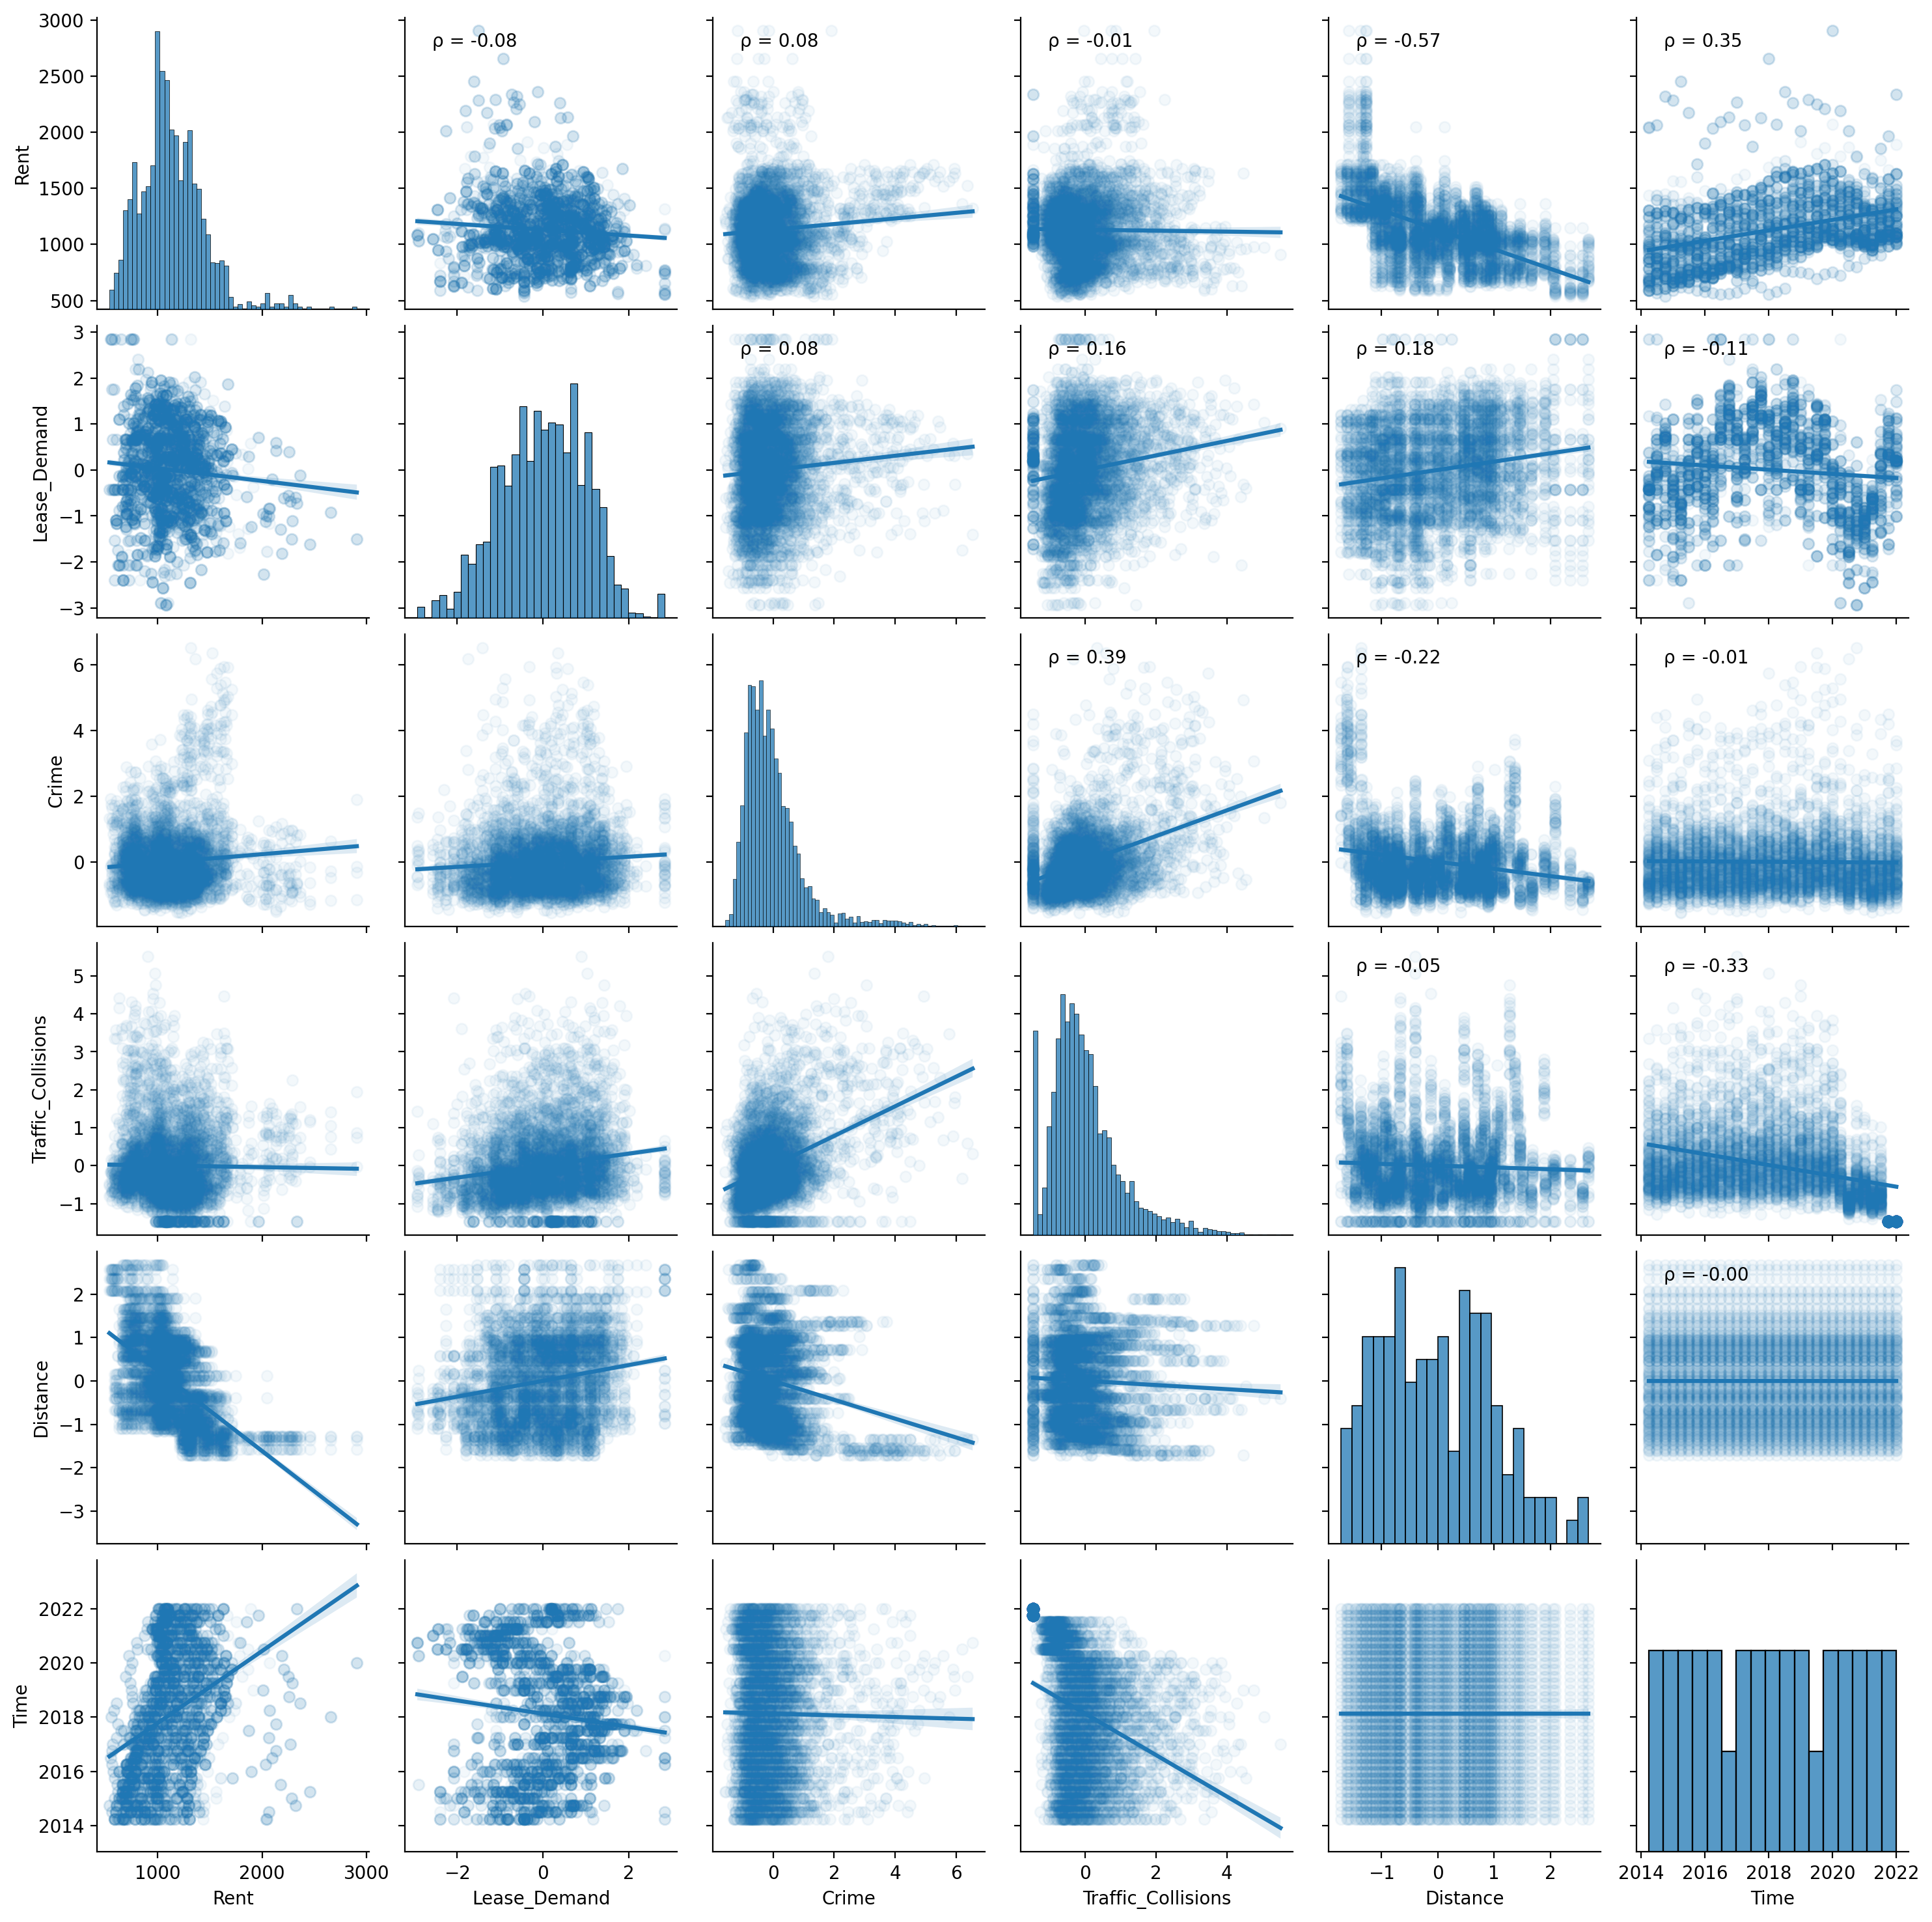

In [16]:
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r = np.corrcoef(x, y)[0,1]
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
g = sns.pairplot(regression_df[[Y] + Xs_numeric + ['Time']], 
             kind = 'reg', 
             diag_kind='hist', 
             plot_kws={'scatter_kws': {'alpha':0.05}})
g.map_upper(corrfunc)
g

# Panel data regression result
- Our data is a panel data with time and hood_ID
- Instead of doing a pooled OLS, let's take into account of the time and neighbourhood_ID to build a LSDV model
  - fixed effects instead of random effects
    - fixed effects eliminate omitted variable bias -> improve interpretability of coefficients
    - fixed effects do not assume any particular distribution
- Trade-off between flexibility to measure heterogenity, and pooling data to estimate shared parameters more precisely
- https://faculty.washington.edu/cadolph/?page=24 

## Best-subsets regression
- Variable selection procedure for a specified number of independent variables based on adjusted R square
- Given there is no significant benefit from including variables other than distance, let's use that as our model

In [17]:
def flatten(l):
    for el in l:
        if isinstance(el, Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el

In [18]:
# https://www.statsmodels.org/devel/example_formulas.html
best_models = []
for i in range(len(Xs)):
    n = i + 1
    best_rsq = 0
    best_combo = []
    for combo in itertools.combinations(Xs, n):
        rsq_adj = smf.ols(formula = Y + ' ~ ' + ' + '.join(combo), data = regression_df).fit().rsquared_adj
        if rsq_adj > best_rsq:
            best_combo = combo
            best_rsq = rsq_adj
    best_models.append(best_combo)
    print(f"Highest adjusted R squared achieved with {n} variable(s) = {best_rsq:0.3f} = {Y} ~ {' + '.join(best_combo)}")

Highest adjusted R squared achieved with 1 variable(s) = 0.739 = Rent ~ C(hood_id)
Highest adjusted R squared achieved with 2 variable(s) = 0.868 = Rent ~ Time + C(hood_id)
Highest adjusted R squared achieved with 3 variable(s) = 0.880 = Rent ~ Traffic_Collisions + Time + C(hood_id)
Highest adjusted R squared achieved with 4 variable(s) = 0.882 = Rent ~ Lease_Demand + Traffic_Collisions + Time + C(hood_id)
Highest adjusted R squared achieved with 5 variable(s) = 0.882 = Rent ~ Lease_Demand + Traffic_Collisions + Time + C(Quarter) + C(hood_id)
Highest adjusted R squared achieved with 6 variable(s) = 0.882 = Rent ~ Lease_Demand + Crime + Traffic_Collisions + Time + C(Quarter) + C(hood_id)
Highest adjusted R squared achieved with 7 variable(s) = 0.882 = Rent ~ Lease_Demand + Crime + Traffic_Collisions + Distance + Time + C(Quarter) + C(hood_id)


In [19]:
# Let's pick the best model with 3 variables as R squared does not seem to improve after adding extra variables
Xs_best_subset = ['Traffic_Collisions', 'Time', 'C(hood_id)']
best_subset = smf.ols(formula = Y + ' ~ ' + ' + '.join(Xs_best_subset), data = regression_df).fit()

In [20]:
# Significant F value
print(f"F value: {best_subset.fvalue:0.3f}, p-value: {best_subset.f_pvalue:0.3f}")

F value: 234.013, p-value: 0.000


### First take
- While F test is significant, we need to rule out the impact from outliers, influential observations and multicollinearity
- VIF of Traffic_Collisions at 4.08 suggest some degree of multicollinearity
  - Indeed the positive sign of traffic_collisions to rent is hardly justified
    - Does it mean people prefer apartments in neighbourhood with higher rate of traffic accidents?
    - Does it mean people prefer crowder areas such that there are more cars on the road leading to a higher rate of traffic accidents?
- No outliers and influential observations

In [21]:
# Check multicollinearity
cls = Linear_Reg_Diagnostics(best_subset)
cls.vif_table()

               Features  VIF Factor
139  Traffic_Collisions        3.25
16    C(hood_id)[T.114]        2.17
96     C(hood_id)[T.60]        2.14
7     C(hood_id)[T.106]        2.14
128     C(hood_id)[T.9]        2.14
..                  ...         ...
59     C(hood_id)[T.27]        1.99
34    C(hood_id)[T.130]        1.99
129    C(hood_id)[T.90]        1.99
116    C(hood_id)[T.79]        1.99
140                Time        1.35

[141 rows x 2 columns]


### Model refinement
- Let's pick the best model with 2 variables instead
  1) VIF of Traffic_Collisions suggest some degree of multicollinearity
  2) While adding Traffic_Collisions can improve the model, it does not seem to be significant based on the correlation plot
  3) Keeping time and hood_id as indepednet variables can also make prediction easier as both are fixed variables

In [22]:
# Let's pick the best model with 2 variables
# 1) while adding Traffic_Collisions can improve the model, it does not seem to be significant based on the correlation plot
# 2) keeping time and hood_id as indepednet variables can also make prediction easier as both are fixed variables
Xs_best_subset = ['Time', 'C(hood_id)']
best_subset = smf.ols(formula = Y + ' ~ ' + ' + '.join(Xs_best_subset), data = regression_df).fit()

In [23]:
best_subset.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rent   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     210.5
Date:                Sun, 05 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:25:16   Log-Likelihood:                -27404.
No. Observations:                4480   AIC:                         5.509e+04
Df Residuals:                    4339   BIC:                         5.599e+04
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -9.354e+04   1456.437    -64.226      0.000   -9.64e+04   -9.07e+04
C(hood_id)[T.10]    208.6395     27.872      7.486      0.000     153.996     263.283
C(hood_id)[T.100]   439.2182     27.872     15.758      0.000     384.575     493.862
C(hood_id)[T.101]   439.2182     27.872     15.758      0.000     384.575     493.862
C(hood_id)[T.102]   401.7984     27.872     14.416      0.000     347.155     456.442
C(hood_id)[T.103]   401.7984     27.872     14.416      0.000     347.155     456.442
C(hood_id)[T.104]   482.2866     27.872     17.304      0.000     427.643     536.930
C(hood_id)[T.105]   401.7984     27.872     14.416      0.000     347.155     456.442
C(hood_id)[T.106]   439.2182     27.872     15.758      0.000     384.575     493.862
C(hood_id)[T.107]   439.2182     27.872     15.758      0.000     384.575     493.862
C(hood_id)[T.108]    64.1852     27.872      2.303      0.021       9.542     118.829
C(hood_id)[T.109]    37.8383     27.872      1.358      0.175     -16.805      92.482
C(hood_id)[T.11]    208.6395     27.872      7.486      0.000     153.996     263.283
C(hood_id)[T.110]    37.8383     27.872      1.358      0.175     -16.805      92.482
C(hood_id)[T.111]    37.8383     27.872      1.358      0.175     -16.805      92.482
C(hood_id)[T.112]    64.1852     27.872      2.303      0.021       9.542     118.829
C(hood_id)[T.113]    64.1852     27.872      2.303      0.021       9.542     118.829
C(hood_id)[T.114]   380.8184     27.872     13.663      0.000     326.175     435.462
C(hood_id)[T.115]    64.1852     27.872      2.303      0.021       9.542     118.829
C(hood_id)[T.116]    46.1048     27.872      1.654      0.098      -8.539     100.748
C(hood_id)[T.117]    46.1048     27.872      1.654      0.098      -8.539     100.748
C(hood_id)[T.118]    46.1048     27.872      1.654      0.098      -8.539     100.748
C(hood_id)[T.119]   -13.8855     27.872     -0.498      0.618     -68.529      40.758
C(hood_id)[T.12]    208.6395     27.872      7.486      0.000     153.996     263.283
C(hood_id)[T.120]   -13.8855     27.872     -0.498      0.618     -68.529      40.758
C(hood_id)[T.121]   241.7626     27.872      8.674      0.000     187.119     296.406
C(hood_id)[T.122]   241.7626     27.872      8.674      0.000     187.119     296.406
C(hood_id)[T.123]   -44.3831     27.872     -1.592      0.111     -99.027      10.260
C(hood_id)[T.124]   -13.8855     27.872     -0.498      0.618     -68.529      40.758
C(hood_id)[T.125]   -13.8855     27.872     -0.498      0.618     -68.529      40.758
C(hood_id)[T.126]   -13.8855     27.872     -0.498      0.618     -68.529      40.758
C(hood_id)[T.127]   115.6219     27.872      4.148      0.000      60.978     170.266
C(hood_id)[T.128]    25.3932     27.872      0.911      0.362     -29.250

### Intuitive interpretation
- If we plot the Rent vs Time, you can see there is a general upward slope due to inflation
- If we group each neighbourhood, you can see while the slope is generally similar, they have 
  - different intercepts, and
  - similar slopes
- More expensive regions will tend to be more expensive

c:\Users\willi\miniconda3\envs\police\lib\site-packages\seaborn\regression.py:581: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



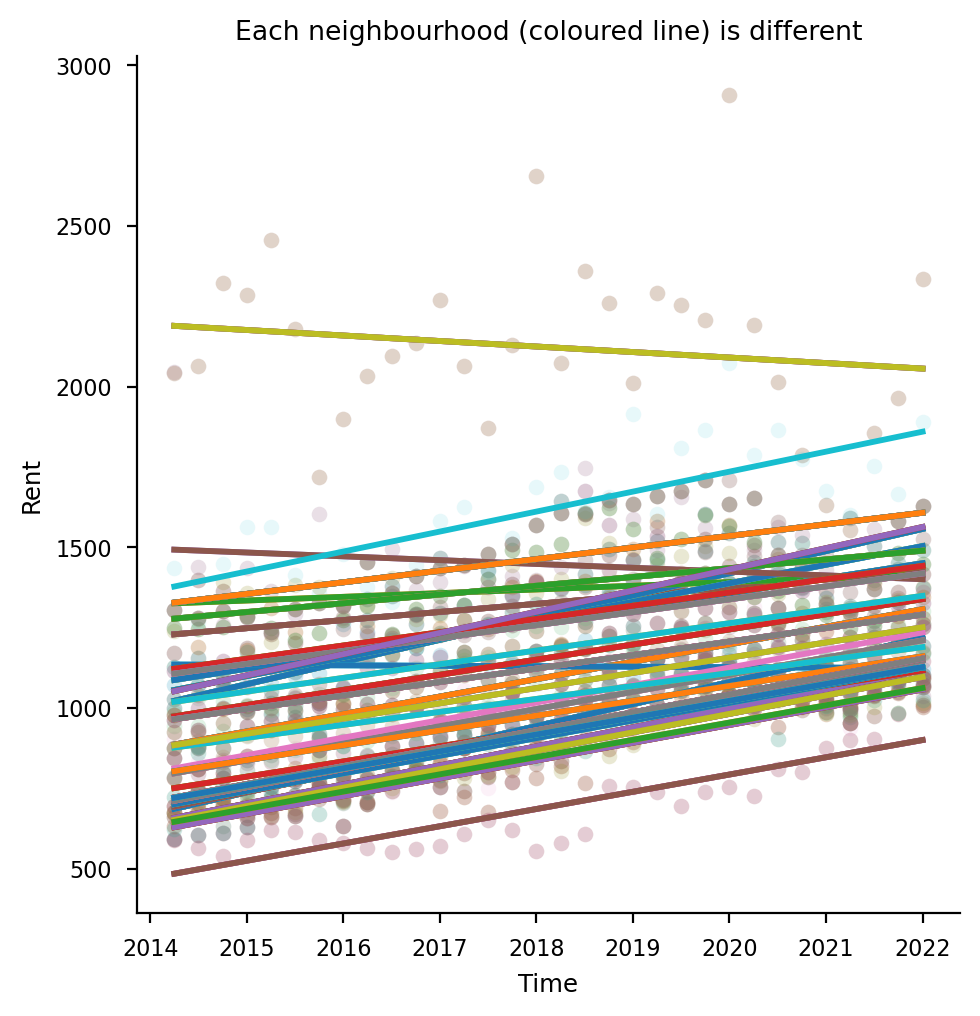

In [24]:
with plt.style.context('seaborn-paper'):
    sns.lmplot(x='Time', y='Rent', data=regression_df, hue='hood_id', palette='tab10', legend=False, ci=None, scatter_kws={'alpha':0.10}, size=5)
    plt.title('Each neighbourhood (coloured line) is different')

### Residual diagnostics

- Mulptiple signs show that the assumptions about regression residuals are violated 
  - Upper left: expected value of residuals is close to 0 but not constant across fitted values (y_hat)
  - Lower left: signs of heteroscedasticity and autocorrelation among residuals suggested by Ljung-Box test
  - Upper right: residuals do not follow normal distribution suggested by Jarque-Bera test and q-q plot
  - Lower right: there are no outliers or influential observations with Cook's distance > 1


Although the above departures from the assumptions might not be extreme enough to make the standard error of estimated parameters completely unreliable, 
  > let's not interpret the statistical tests first and verify the results with bootstrapping instead

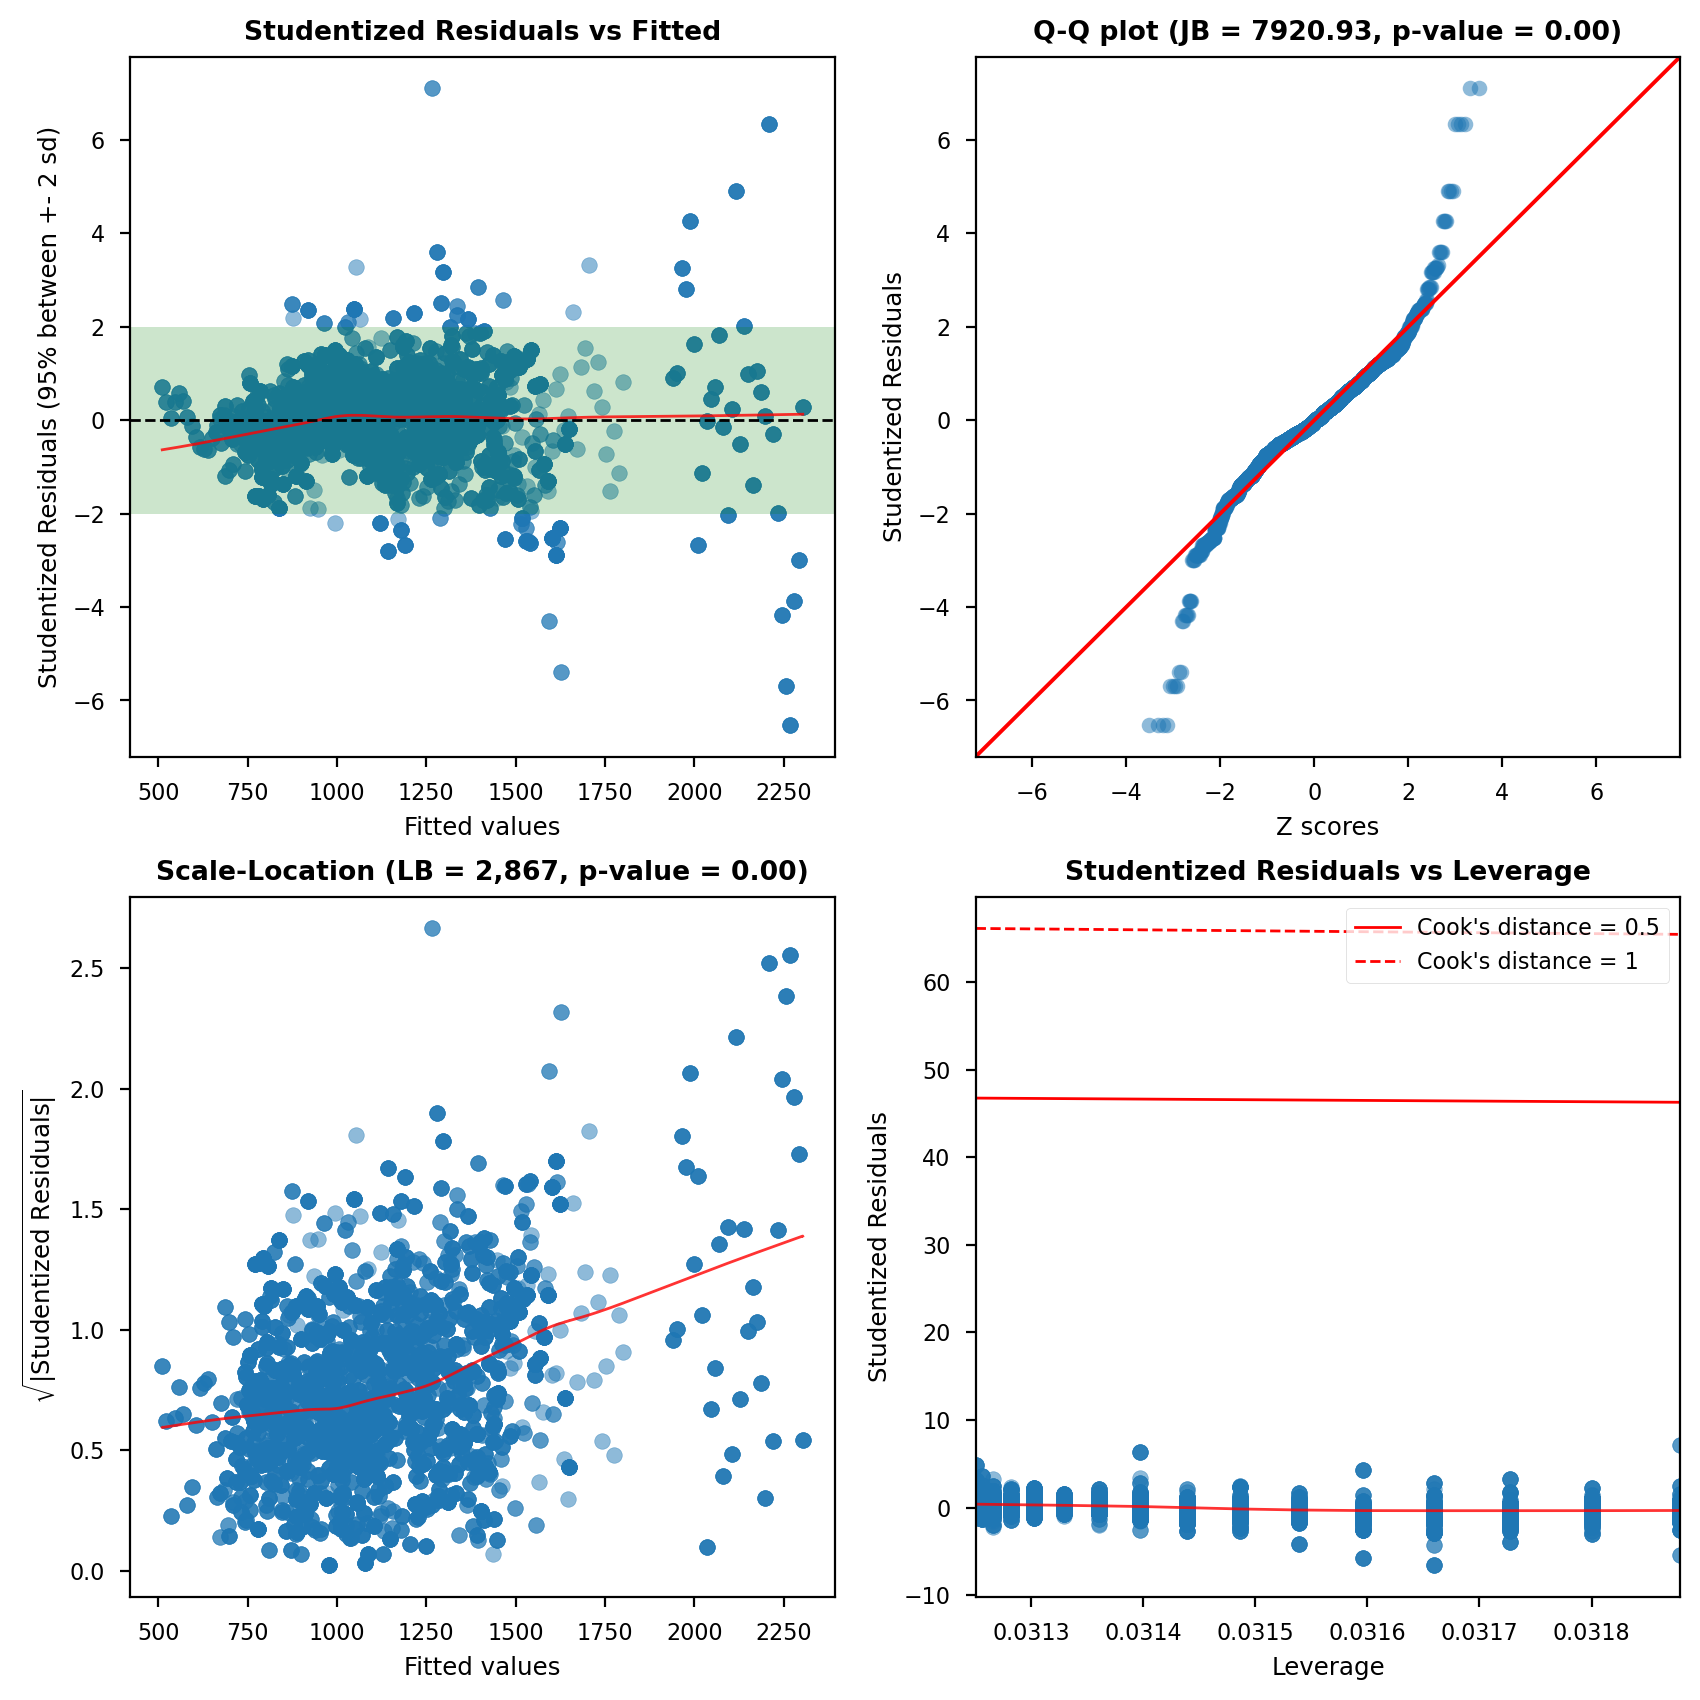

              Features  VIF Factor
104   C(hood_id)[T.68]        1.99
50    C(hood_id)[T.19]        1.99
91    C(hood_id)[T.56]        1.99
0     C(hood_id)[T.10]        1.99
84     C(hood_id)[T.5]        1.99
..                 ...         ...
95     C(hood_id)[T.6]        1.99
62     C(hood_id)[T.3]        1.99
105   C(hood_id)[T.69]        1.99
27   C(hood_id)[T.124]        1.99
139               Time        1.00

[140 rows x 2 columns]


In [25]:
# Let's check the residuals and multicollinearity again
cls = Linear_Reg_Diagnostics(best_subset)
fig, ax = cls()

### Bootstrapping F test
- While the F statistic suggests significance in our model, the assumptions of residuals are clearly violated 
- Thus we cannot trust that our F statistic will follow the asymptotic F distribution and trust the p-value for now
- Instead let's apply bootstrapping to see if our F statistic is really significant
- Bootstrapping Regression Models https://artowen.su.domains/courses/305-1314/FoxOnBootingRegInR.pdf
- https://stats.stackexchange.com/questions/59670/multiple-regression-and-multiple-comparisons
- https://stats.stackexchange.com/questions/167289/is-there-a-multiple-testing-problem-when-performing-t-tests-for-multiple-coeffci
- https://online.stat.psu.edu/stat462/node/135/

In [26]:
print(f"F value: {best_subset.fvalue}, p-value: {best_subset.f_pvalue:0.3f}")

F value: 210.52309181243496, p-value: 0.000


In [27]:
# compute F statistic to indicate the significance of extra variables by comparing the restricted vs full regression model
# def compute_F(formula_full, formula_restricted = None, data = regression_df, intercept_only = False):
#     full_model = smf.ols(formula = formula_full, data = data).fit()
    
#     if intercept_only:
#         # only consider the intercept
#         restricted_model = sm.OLS(regression_df[Y], np.ones(len(regression_df[Y]))).fit()
#     else:
#         restricted_model = smf.ols(formula = formula_restricted, data = data).fit()
#     F_value = (restricted_model.ssr - full_model.ssr) / (restricted_model.df_resid - full_model.df_resid) / (full_model.ssr / full_model.df_resid)
#     return F_value

# compute_F(formula_full= Y + ' ~ ' + ' + '.join(Xs_best_subset),
#           intercept_only=True)

In [28]:
# function to compute F value given the Y and Xs
def compute_F(df, null_true = False):
    X_df = pd.concat([pd.get_dummies(df['hood_id'], drop_first = True), df['Time']], axis=1)
    X_df.insert(0, 'Intercept', 1)
    X_df = X_df.values
    # speed up regression with matrix inverse method
    coef = np.linalg.inv(X_df.T @ X_df) @ X_df.T @ df[Y].values
    if null_true:
        # if null hypothesis of F test is true, all coefficients are zero except the intercept
        # Y would be a series of intercept + residuals
        resid = df[Y].values - X_df @ coef
        intercept = coef[0]
        Y_df = np.random.choice(intercept + resid, size = len(df[Y]), replace = True)
    else:
        Y_df = df[Y].values
    boot_coef = np.linalg.inv(X_df.T @ X_df) @ X_df.T @ Y_df
    # MSR = sum of squares due to regression / p
    msr = np.sum((X_df @ boot_coef - np.mean(Y_df))**2) / (len(boot_coef) - 1)
    # MSE = sum of squares due to error / (n - p - 1)
    mse = np.sum((Y_df - X_df @ boot_coef)**2) / (len(Y_df) - len(boot_coef))
    f_value = msr / mse
    return f_value

# test
compute_F(regression_df)

210.5230918097843

In [29]:
np.random.seed(123)
# calculating many bootstrap replicates
def draw_bs_reps(df, size=10**4):
    """Draw bootstrap F value of linear regression."""

    # Initialize array of replicates: bs_replicates
    bs_replicate_fvalue = np.empty(size)
    
    # Generate replicates
    with tqdm(total=size) as pbar:
        for i in range(size):
            inds = np.arange(df.shape[0])
            # generate a list of indices with replcaement with the same size as our original dataframe
            # to ensure the distribution of bootstrap replicates is the same as that of our estimated coefficients
            bs_inds = np.random.choice(inds, size = len(inds), replace = True)
            # pairwise bootstrapping on Y and Xs assuming random-x resampling
            # as fixed-x resampling assumes residuals are iid (which is not true as we see the mean and variance is not contsant from residual diagnostics)
            bootstrap_df = df.iloc[bs_inds]
            bs_replicate_fvalue[i] = compute_F(bootstrap_df, null_true=True)
            
            pbar.update(1)

    return bs_replicate_fvalue

In [31]:
# we may consider swithcing to fixed-x resampling if we want to cut the running time 
# as we will only need to run linear regression once instead of twice
bs_fvalue = draw_bs_reps(regression_df)

100%|██████████| 10000/10000 [06:56<00:00, 24.03it/s]


#### Bootstrapping diagnostics
Can we trust the bootstrapping results?
  - Our original sample size is big enough with 4,000+ unique rows to be representative of the underlying population
  - Number of bootstrapped samples at 10,000 is large enough 
  - Distribution of bootstrap F values look like F distribution

All the above signs can give us confidence to use the bootstrap replicates to gauge the statisitcal significance of our F statistic

> Given our bootstrapped F distribution, our observed F statistic is significant at 95% confidence

Text(1.2081429744340317, 500, '95th percentile cutoff = 1.2081')

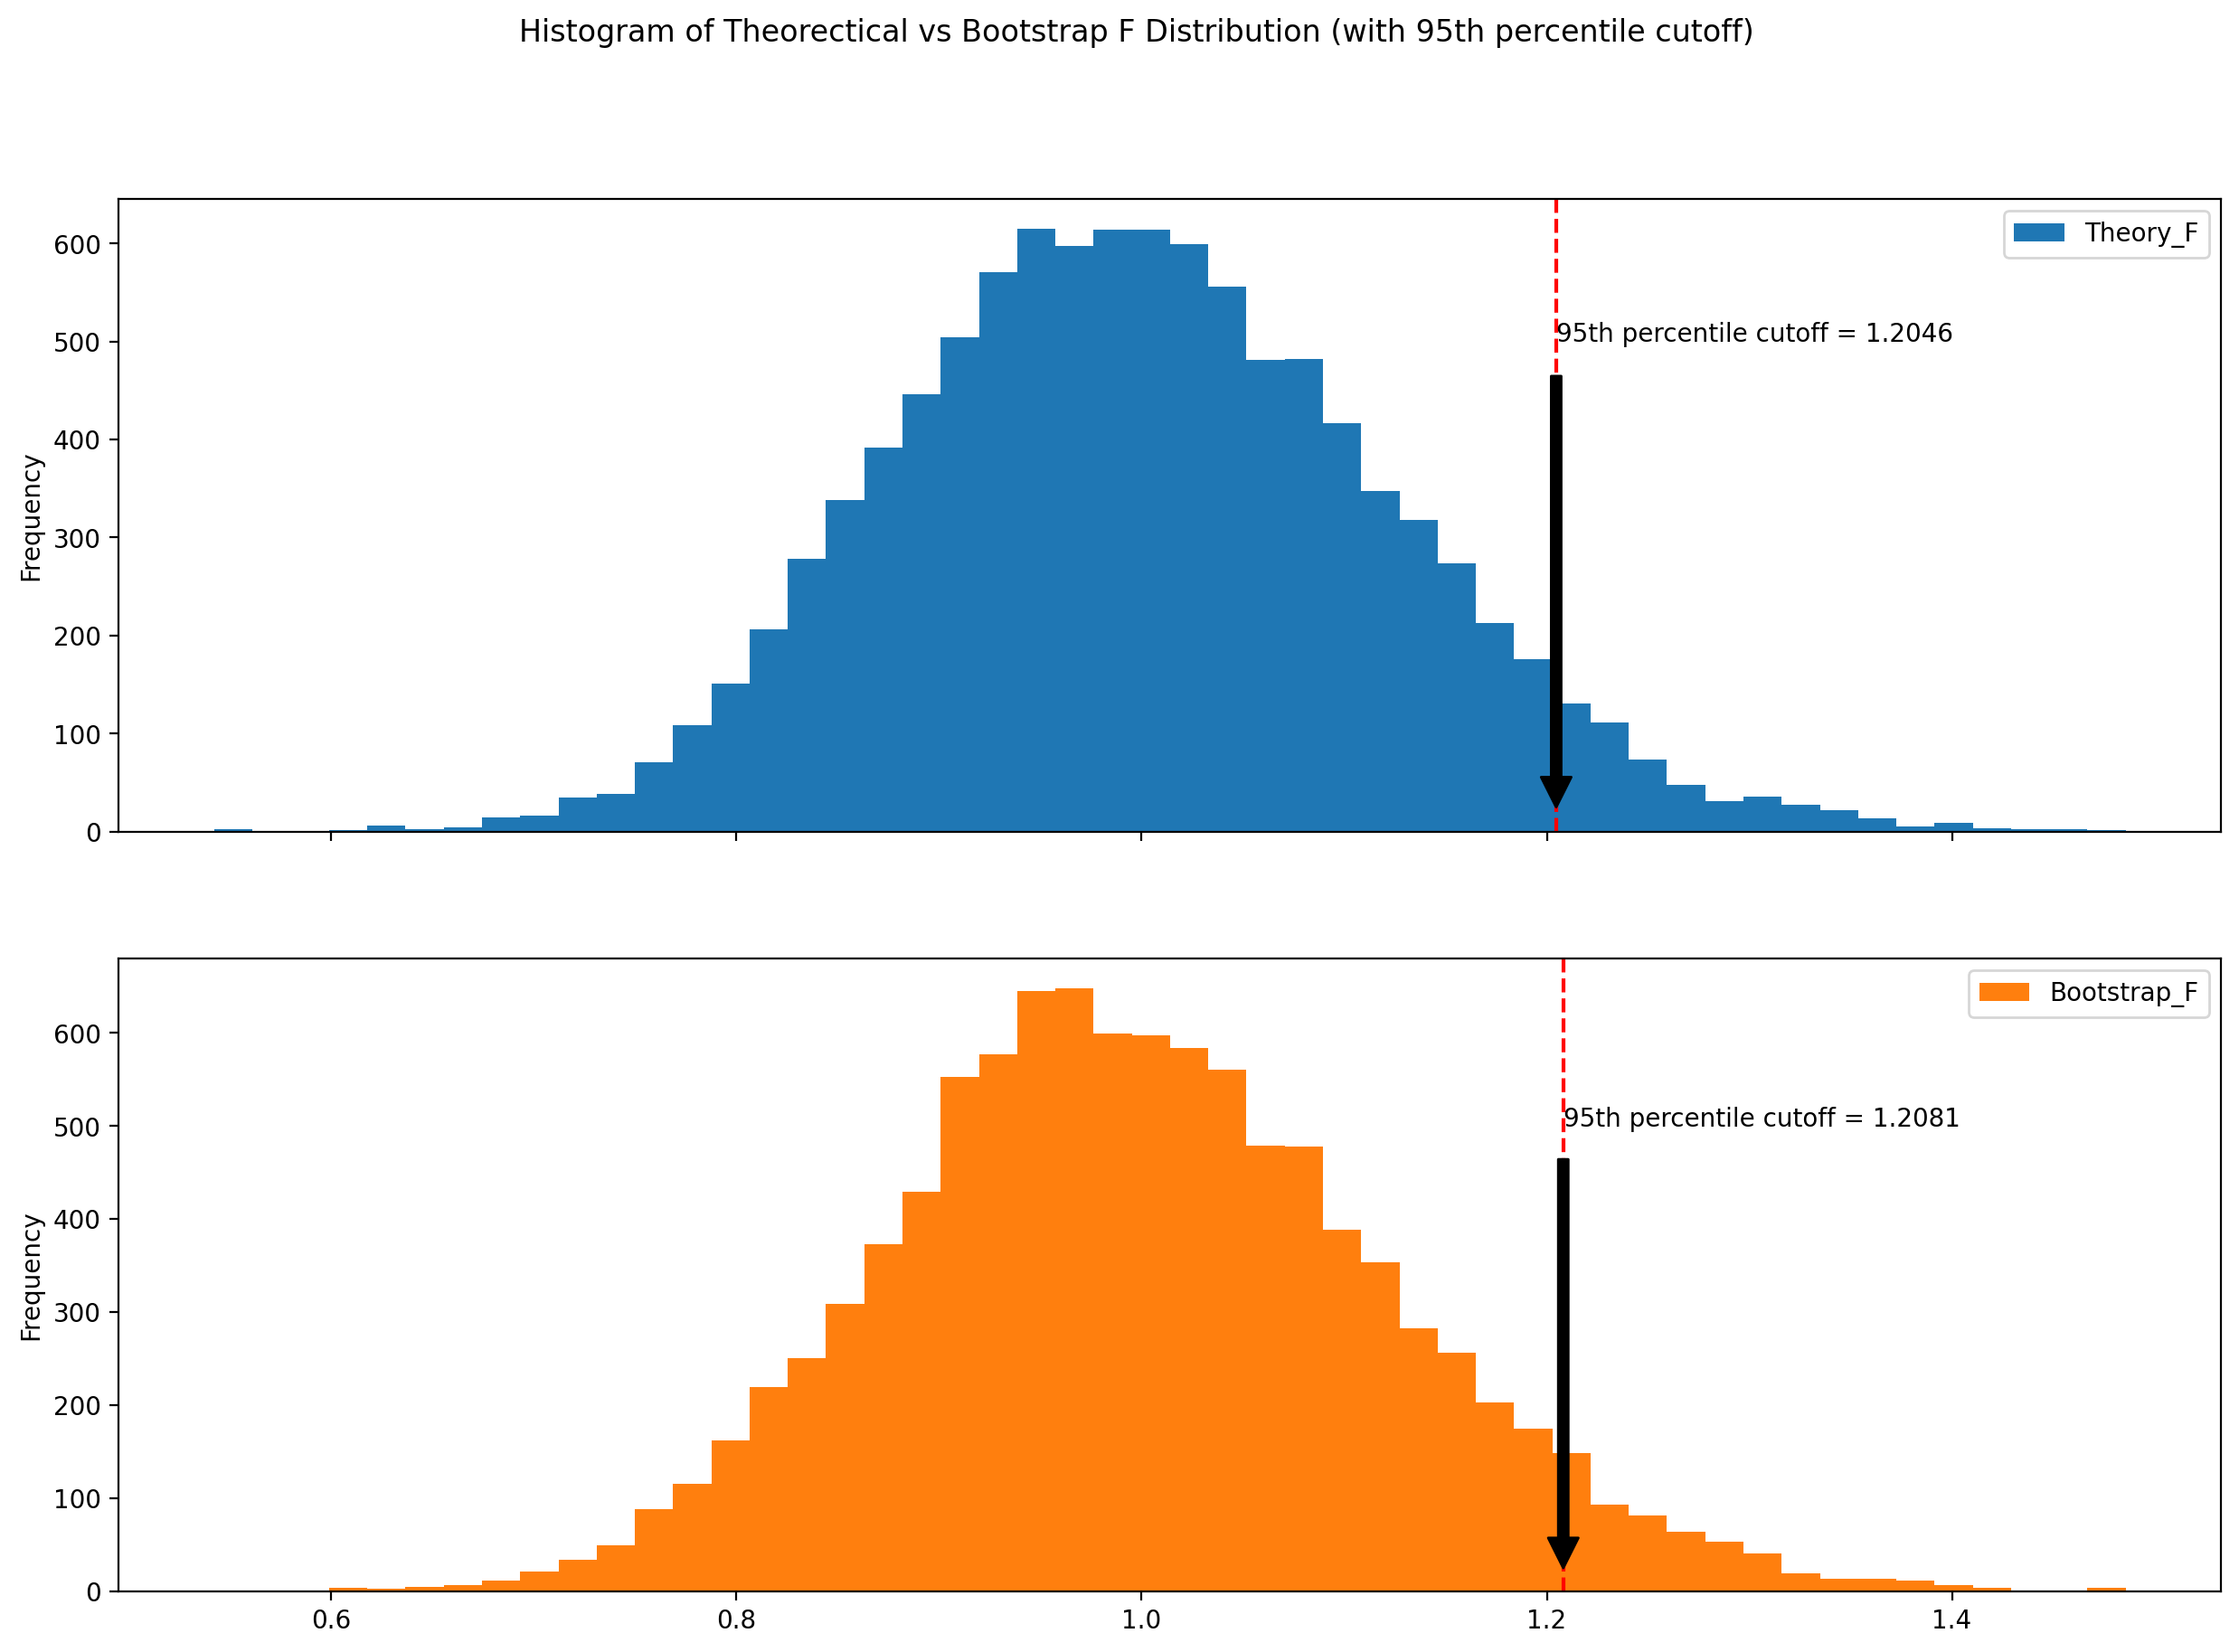

In [32]:
boot_df = pd.DataFrame({'Theory_F': np.random.f(best_subset.df_model, best_subset.df_resid, len(bs_fvalue)),
                        'Bootstrap_F': bs_fvalue})
ax = boot_df.plot(kind = 'hist', subplots = True, bins = 50, title = 'Histogram of Theorectical vs Bootstrap F Distribution (with 95th percentile cutoff)')
ax[0].axvline(boot_df.Theory_F.quantile(0.95), color = 'red', linestyle = '--')
ax[0].annotate(f'95th percentile cutoff = {boot_df.Theory_F.quantile(0.95):0.4f}',
               xy = (boot_df.Theory_F.quantile(0.95), 0), 
               xytext = (boot_df.Theory_F.quantile(0.95), 500), 
               arrowprops = dict(facecolor = 'black', shrink = 0.05))
ax[1].axvline(boot_df.Bootstrap_F.quantile(0.95), color = 'red', linestyle = '--')
ax[1].annotate(f'95th percentile cutoff = {boot_df.Bootstrap_F.quantile(0.95):0.4f}',
               xy = (boot_df.Bootstrap_F.quantile(0.95), 0), 
               xytext = (boot_df.Bootstrap_F.quantile(0.95), 500), 
               arrowprops = dict(facecolor = 'black', shrink = 0.05))

# Time series modelling 

In [33]:
# create df for panel data time series analysis
tseries_df = pd.DataFrame({'Date': pd.to_datetime(regression_table['occurrence_date']),
                           'hood_id': regression_df['hood_id'], 
                           'Rent_Resid': best_subset.resid, 
                           'Crime': regression_df['Crime'],
                           'Traffic_Collisions': regression_df['Traffic_Collisions']})
tseries_df.set_index('Date', inplace = True)
tseries_df.index = tseries_df.index.to_period('q')
tseries_df

hood_id  Rent_Resid     Crime  Traffic_Collisions
Date                                                    
2014Q1       1  -44.877718  1.616749            1.845492
2014Q2       1  -14.860630  2.881757            1.354985
2014Q3       1  -14.678508  1.884004            1.515343
2014Q4       1  -74.188871  2.275978            1.468179
2015Q1       1  -61.759442  1.062016            1.692841
...        ...         ...       ...                 ...
2020Q4      98  -78.881815  0.669737           -0.617220
2021Q1      98 -165.270344  0.204723           -0.947810
2021Q2      98  -25.351842 -0.152640           -0.839697
2021Q3      98 -123.661929  0.204723           -1.474862
2021Q4      98   90.619111  0.511035           -1.474862

[4480 rows x 4 columns]

## Unit root test 
- Im-Pesaran-Shin (2003) test: Pools the units; allows different AR processes.
- LevinLinChu (2002) test: Pools the units; assumes common AR process.
- Maddala-Wu (1999) test: Pools the p-values from separate ADFs; more flexible
- Hadri (2000) test: Also more flexible test; null is stationarity

In [34]:
# test stationarity for the 3 series we want to forecast
# 1st row is test statistic
# 2nd row is p-value of ADF test (if p-value < 0.05, we reject the null hypothesis that the series is random walk)
tseries_df.apply(lambda x: adfuller(x), axis = 0).iloc[:,1:]

Rent_Resid  \
0                                          -9.561681   
1                                                0.0   
2                                                 32   
3                                               4447   
4  {'1%': -3.43182134668231, '5%': -2.86219015833...   
5                                       48533.404754   

                                               Crime  \
0                                          -6.009273   
1                                                0.0   
2                                                 32   
3                                               4447   
4  {'1%': -3.43182134668231, '5%': -2.86219015833...   
5                                        5420.631776   

                                  Traffic_Collisions  
0                                          -9.140501  
1                                                0.0  
2                                                 32  
3                                               4447  
4  {'1%': -3.43182134668231, '5%': -2.86219015833...  
5                                        4440.153611

## ACF, PACF plots

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

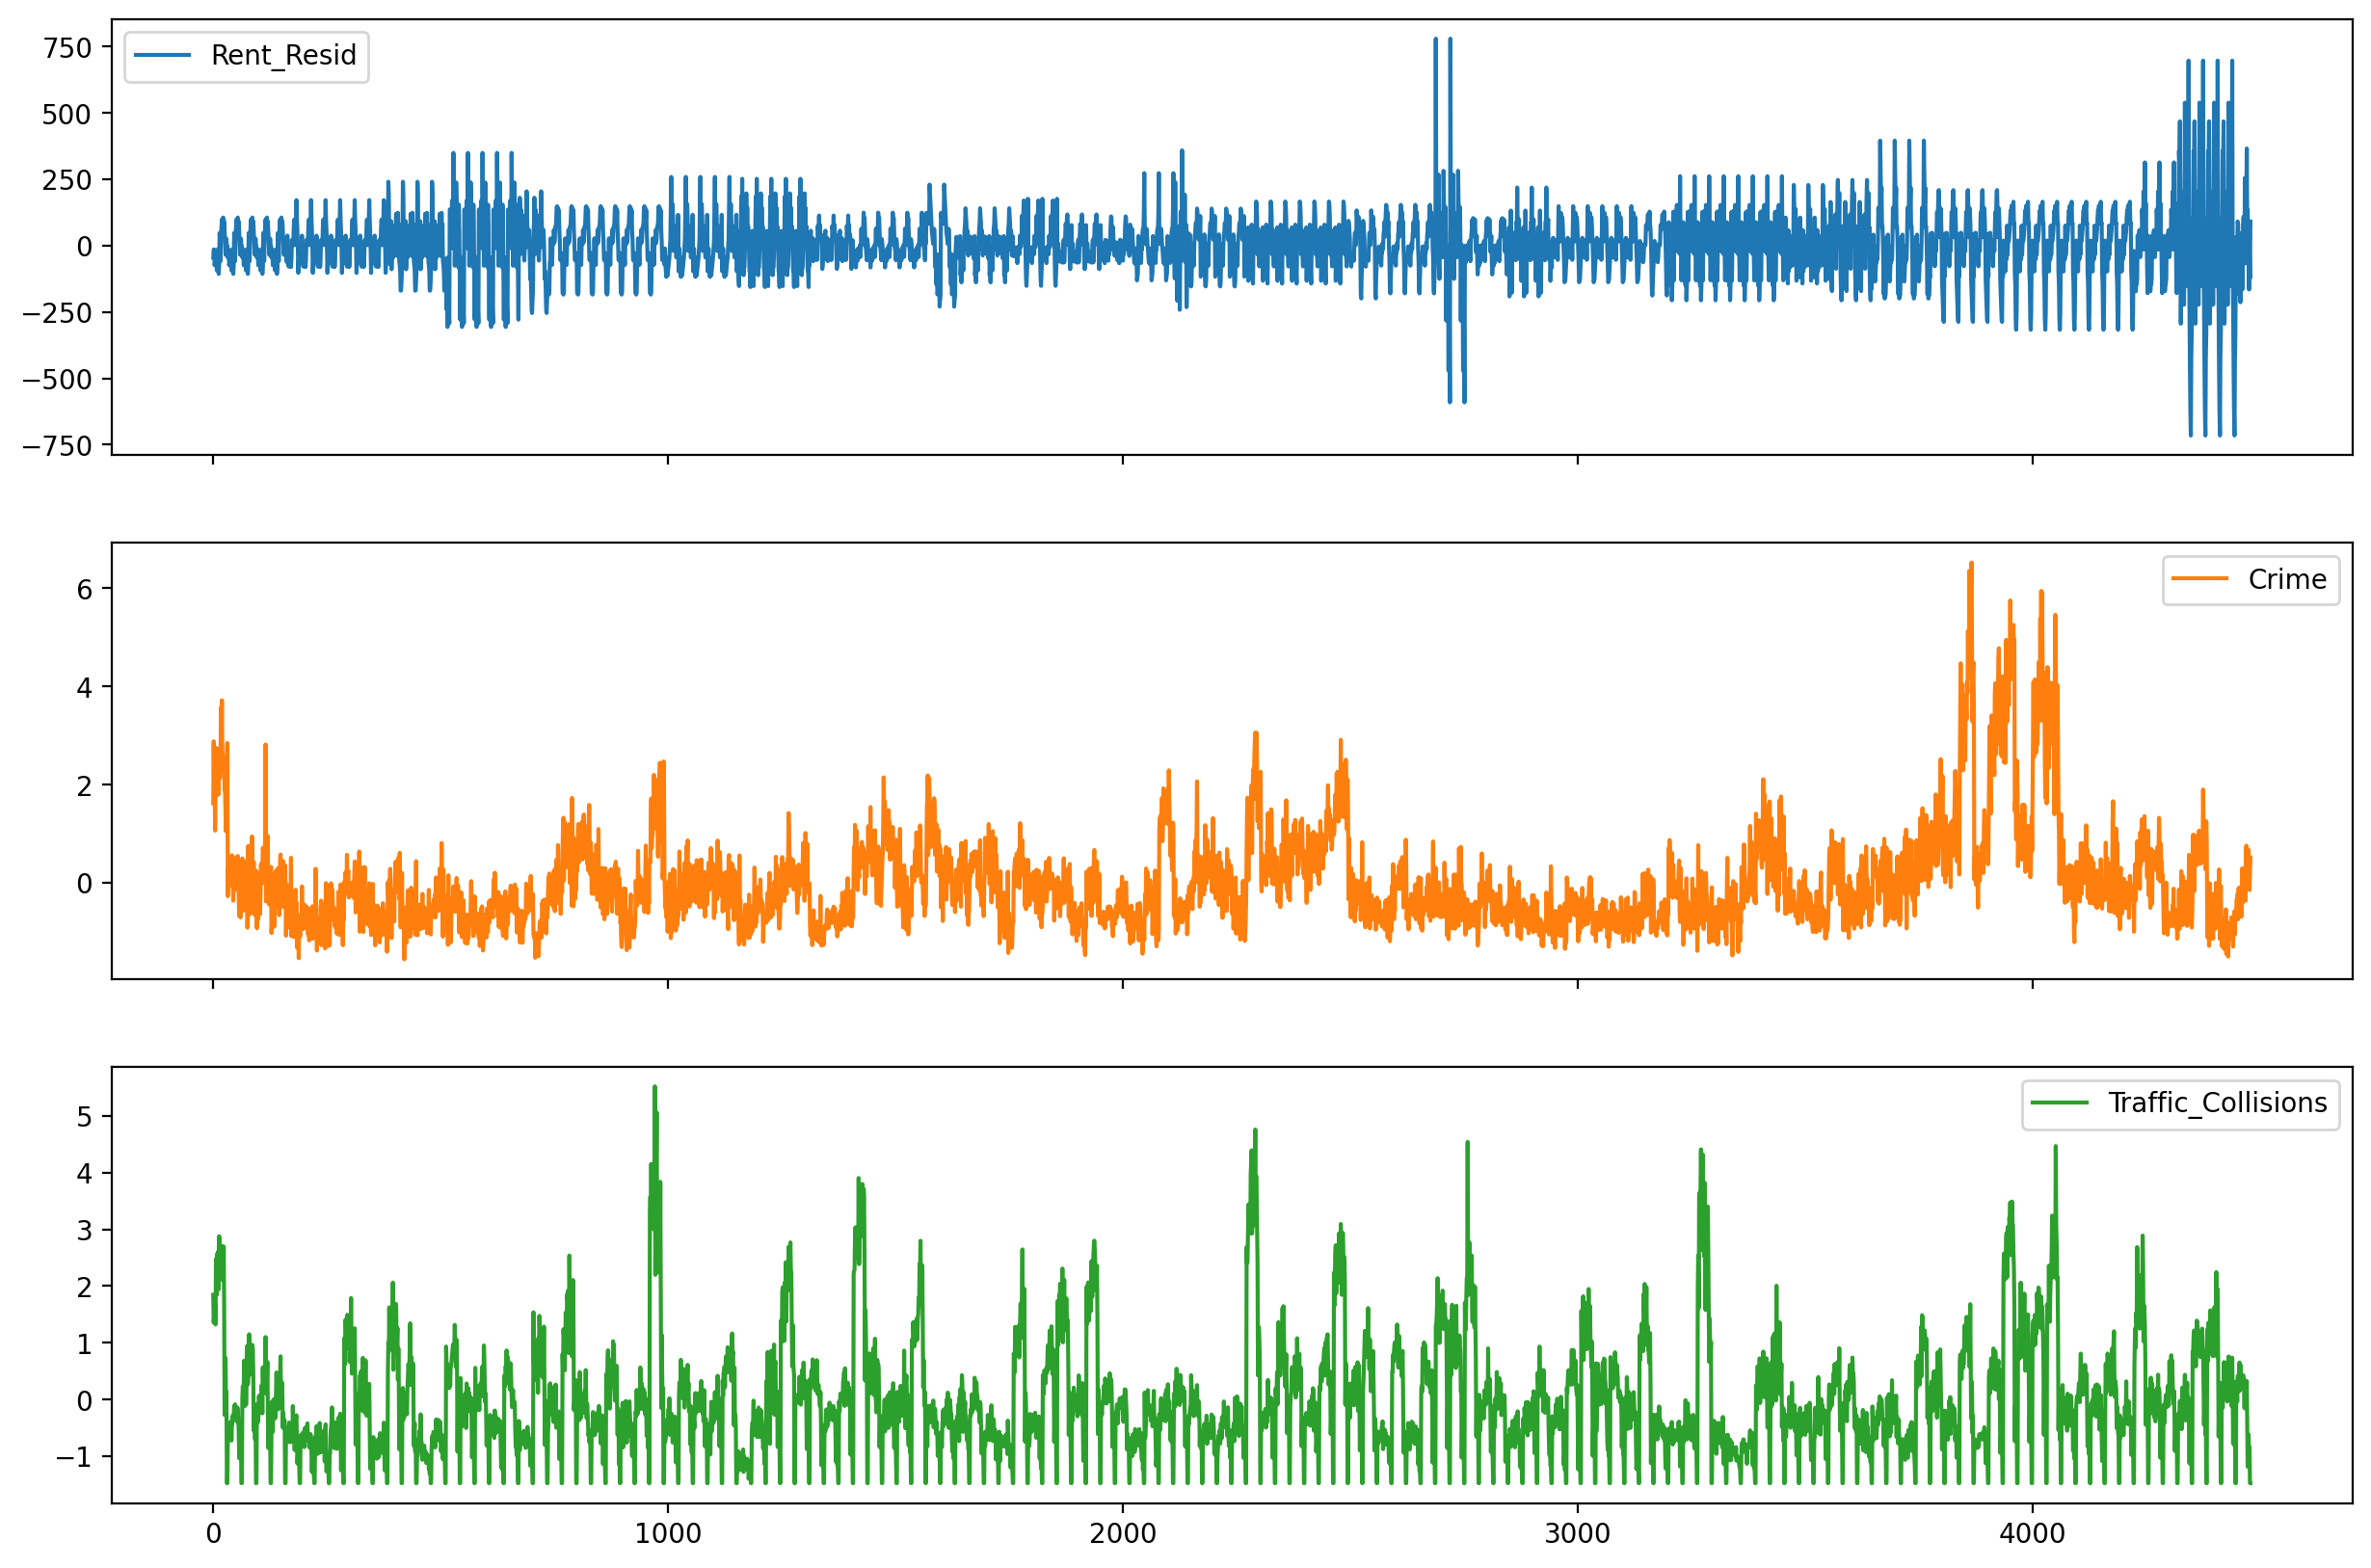

In [35]:
tseries_df.plot(subplots = True, use_index = False)

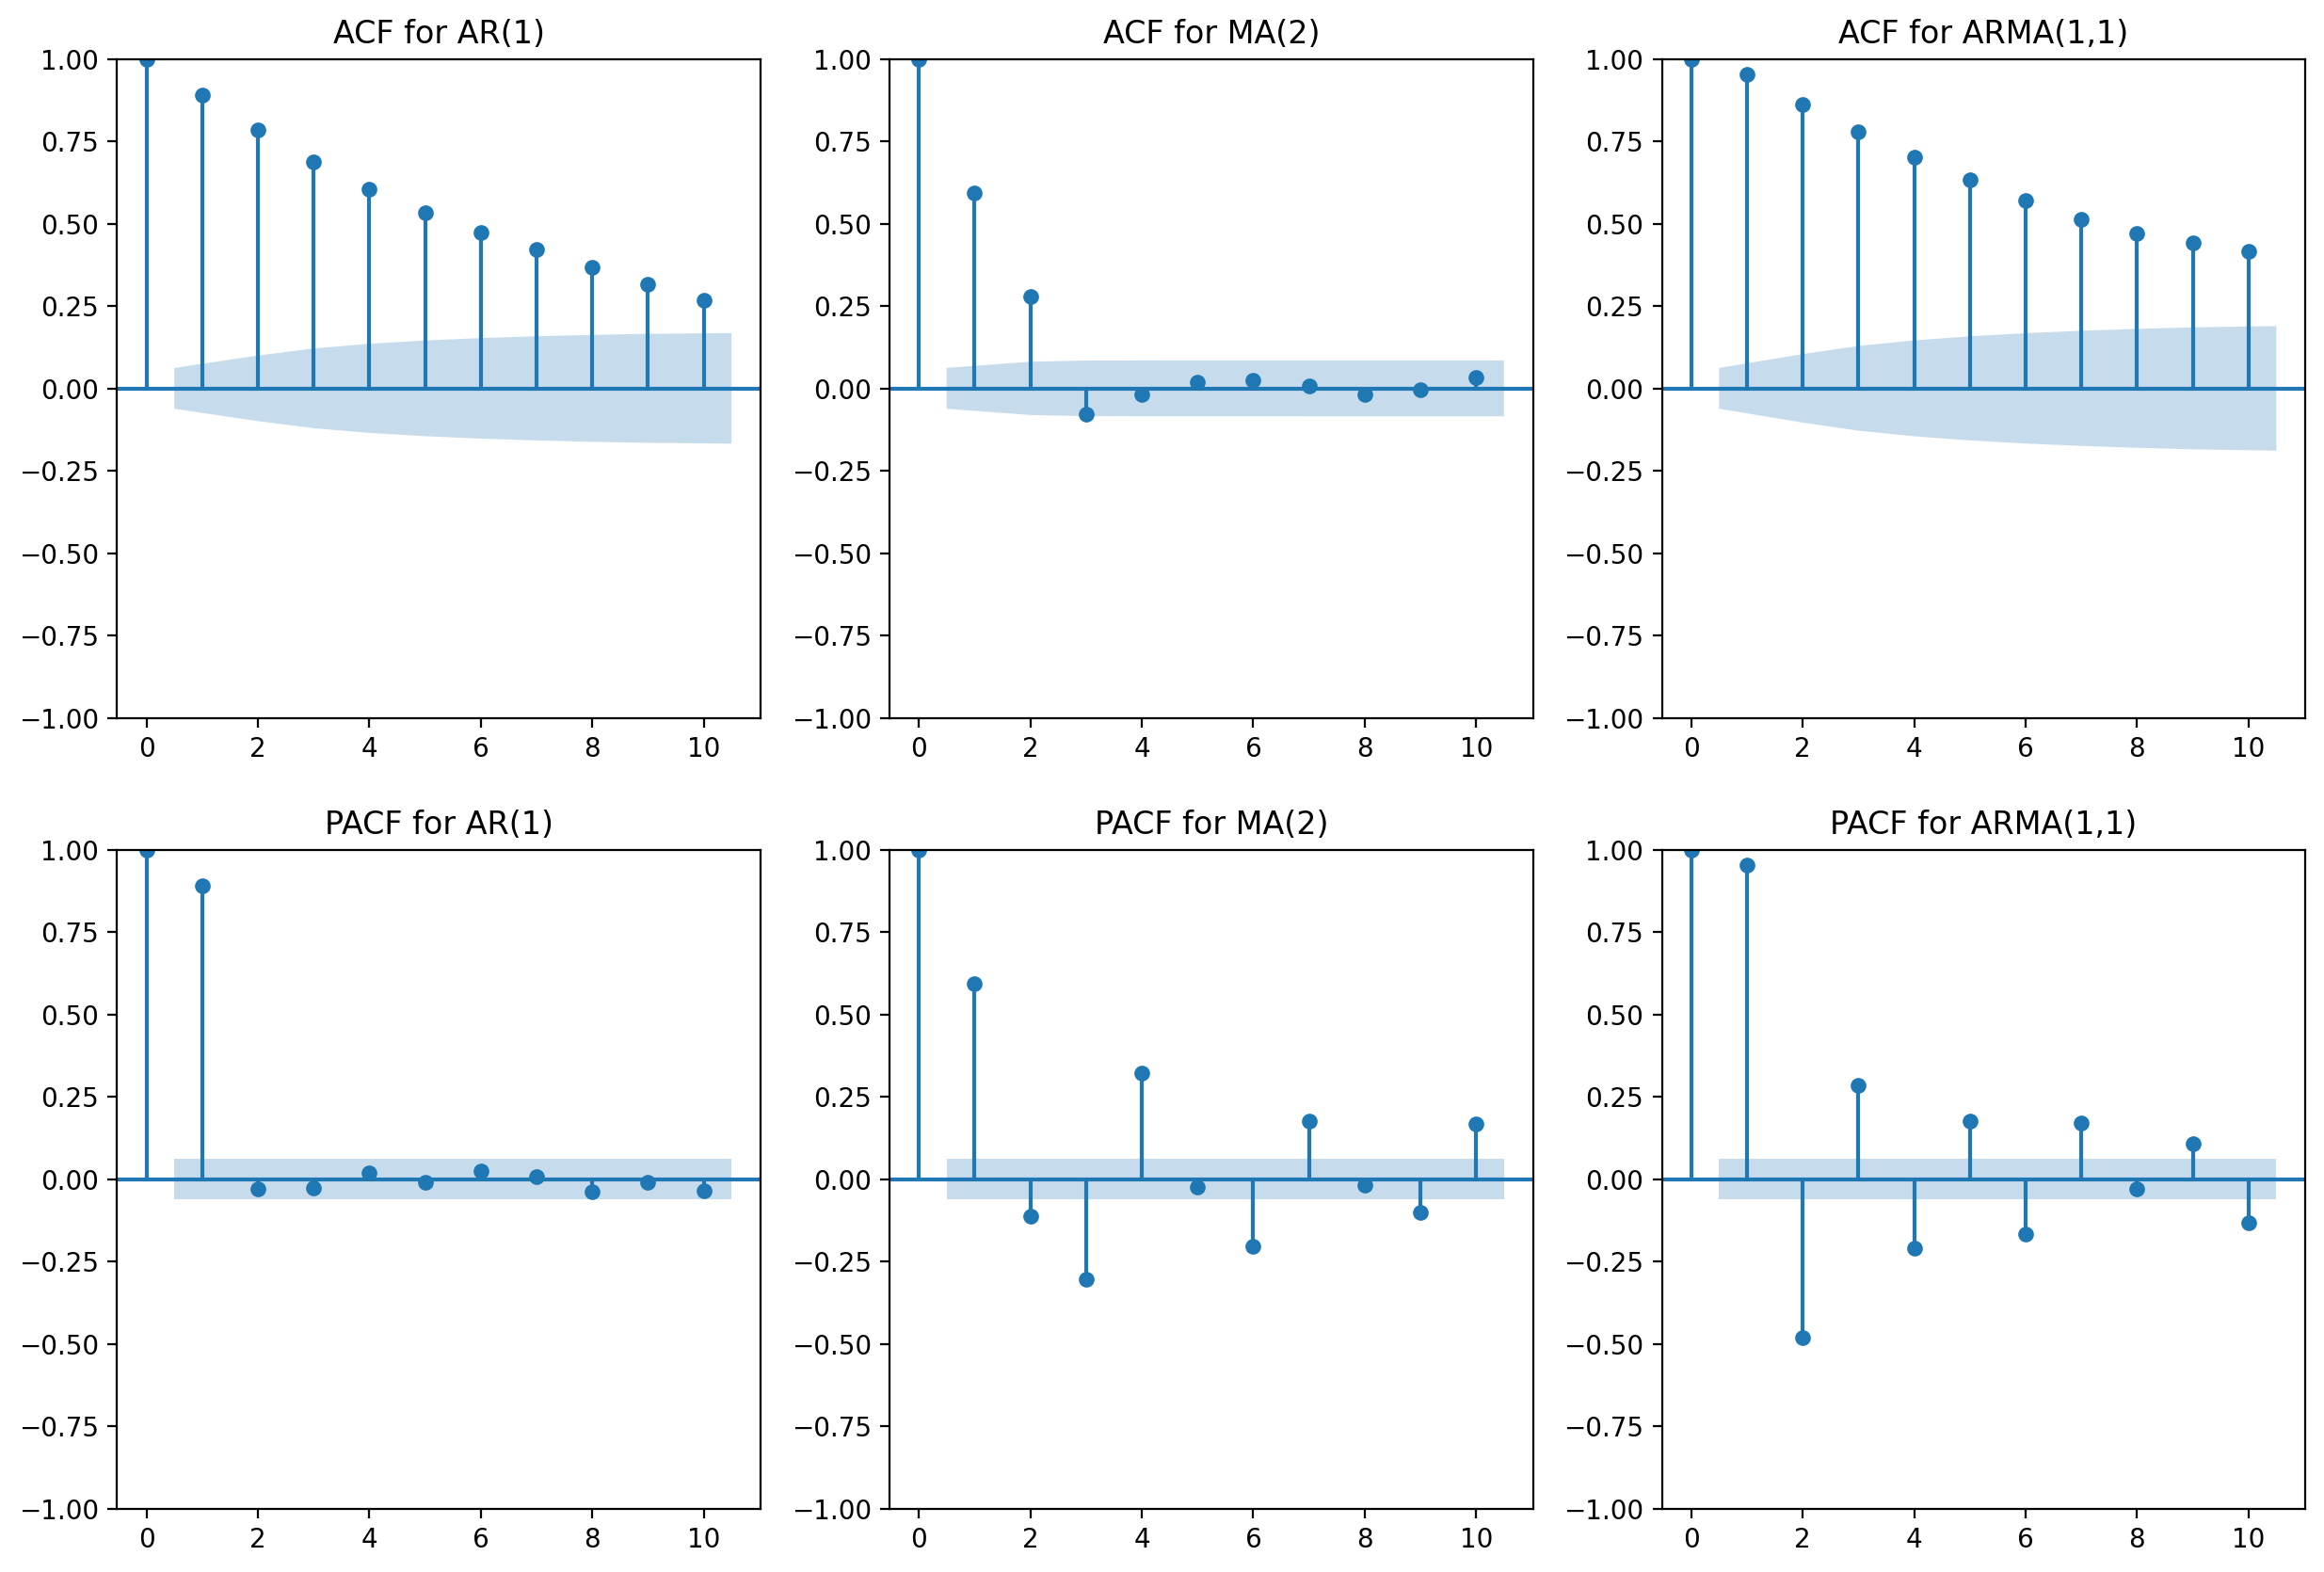

In [36]:
# sample ACF and PACF plot for AR and MA models
ar = np.array([1, -0.9])
ma = np.array([1])
AR_object = ArmaProcess(ar, ma)
simulated_AR = AR_object.generate_sample(nsample = 1000)
ar = np.array([1])
ma = np.array([1, 0.9, 0.9])
MA_object = ArmaProcess(ar, ma)
simulated_MA = MA_object.generate_sample(nsample = 1000)
ar = np.array([1, -0.9])
ma = np.array([1, 0.9])
ARMA_object = ArmaProcess(ar, ma)
simulated_ARMA = ARMA_object.generate_sample(nsample = 1000)
fig, axes = plt.subplots(2, 3)
lag = 10
_ = tsaplots.plot_acf(simulated_AR, lags = lag, ax = axes[0,0], title='ACF for AR(1)')
_ = tsaplots.plot_pacf(simulated_AR, lags = lag, ax = axes[1,0], method = 'ywm', title='PACF for AR(1)')
_ = tsaplots.plot_acf(simulated_MA, lags = lag, ax = axes[0,1], title='ACF for MA(2)')
_ = tsaplots.plot_pacf(simulated_MA, lags = lag, ax = axes[1,1], method = 'ywm', title='PACF for MA(2)')
_ = tsaplots.plot_acf(simulated_ARMA, lags = lag, ax = axes[0,2], title='ACF for ARMA(1,1)')
_ = tsaplots.plot_pacf(simulated_ARMA, lags = lag, ax = axes[1,2], method = 'ywm', title='PACF for ARMA(1,1)')

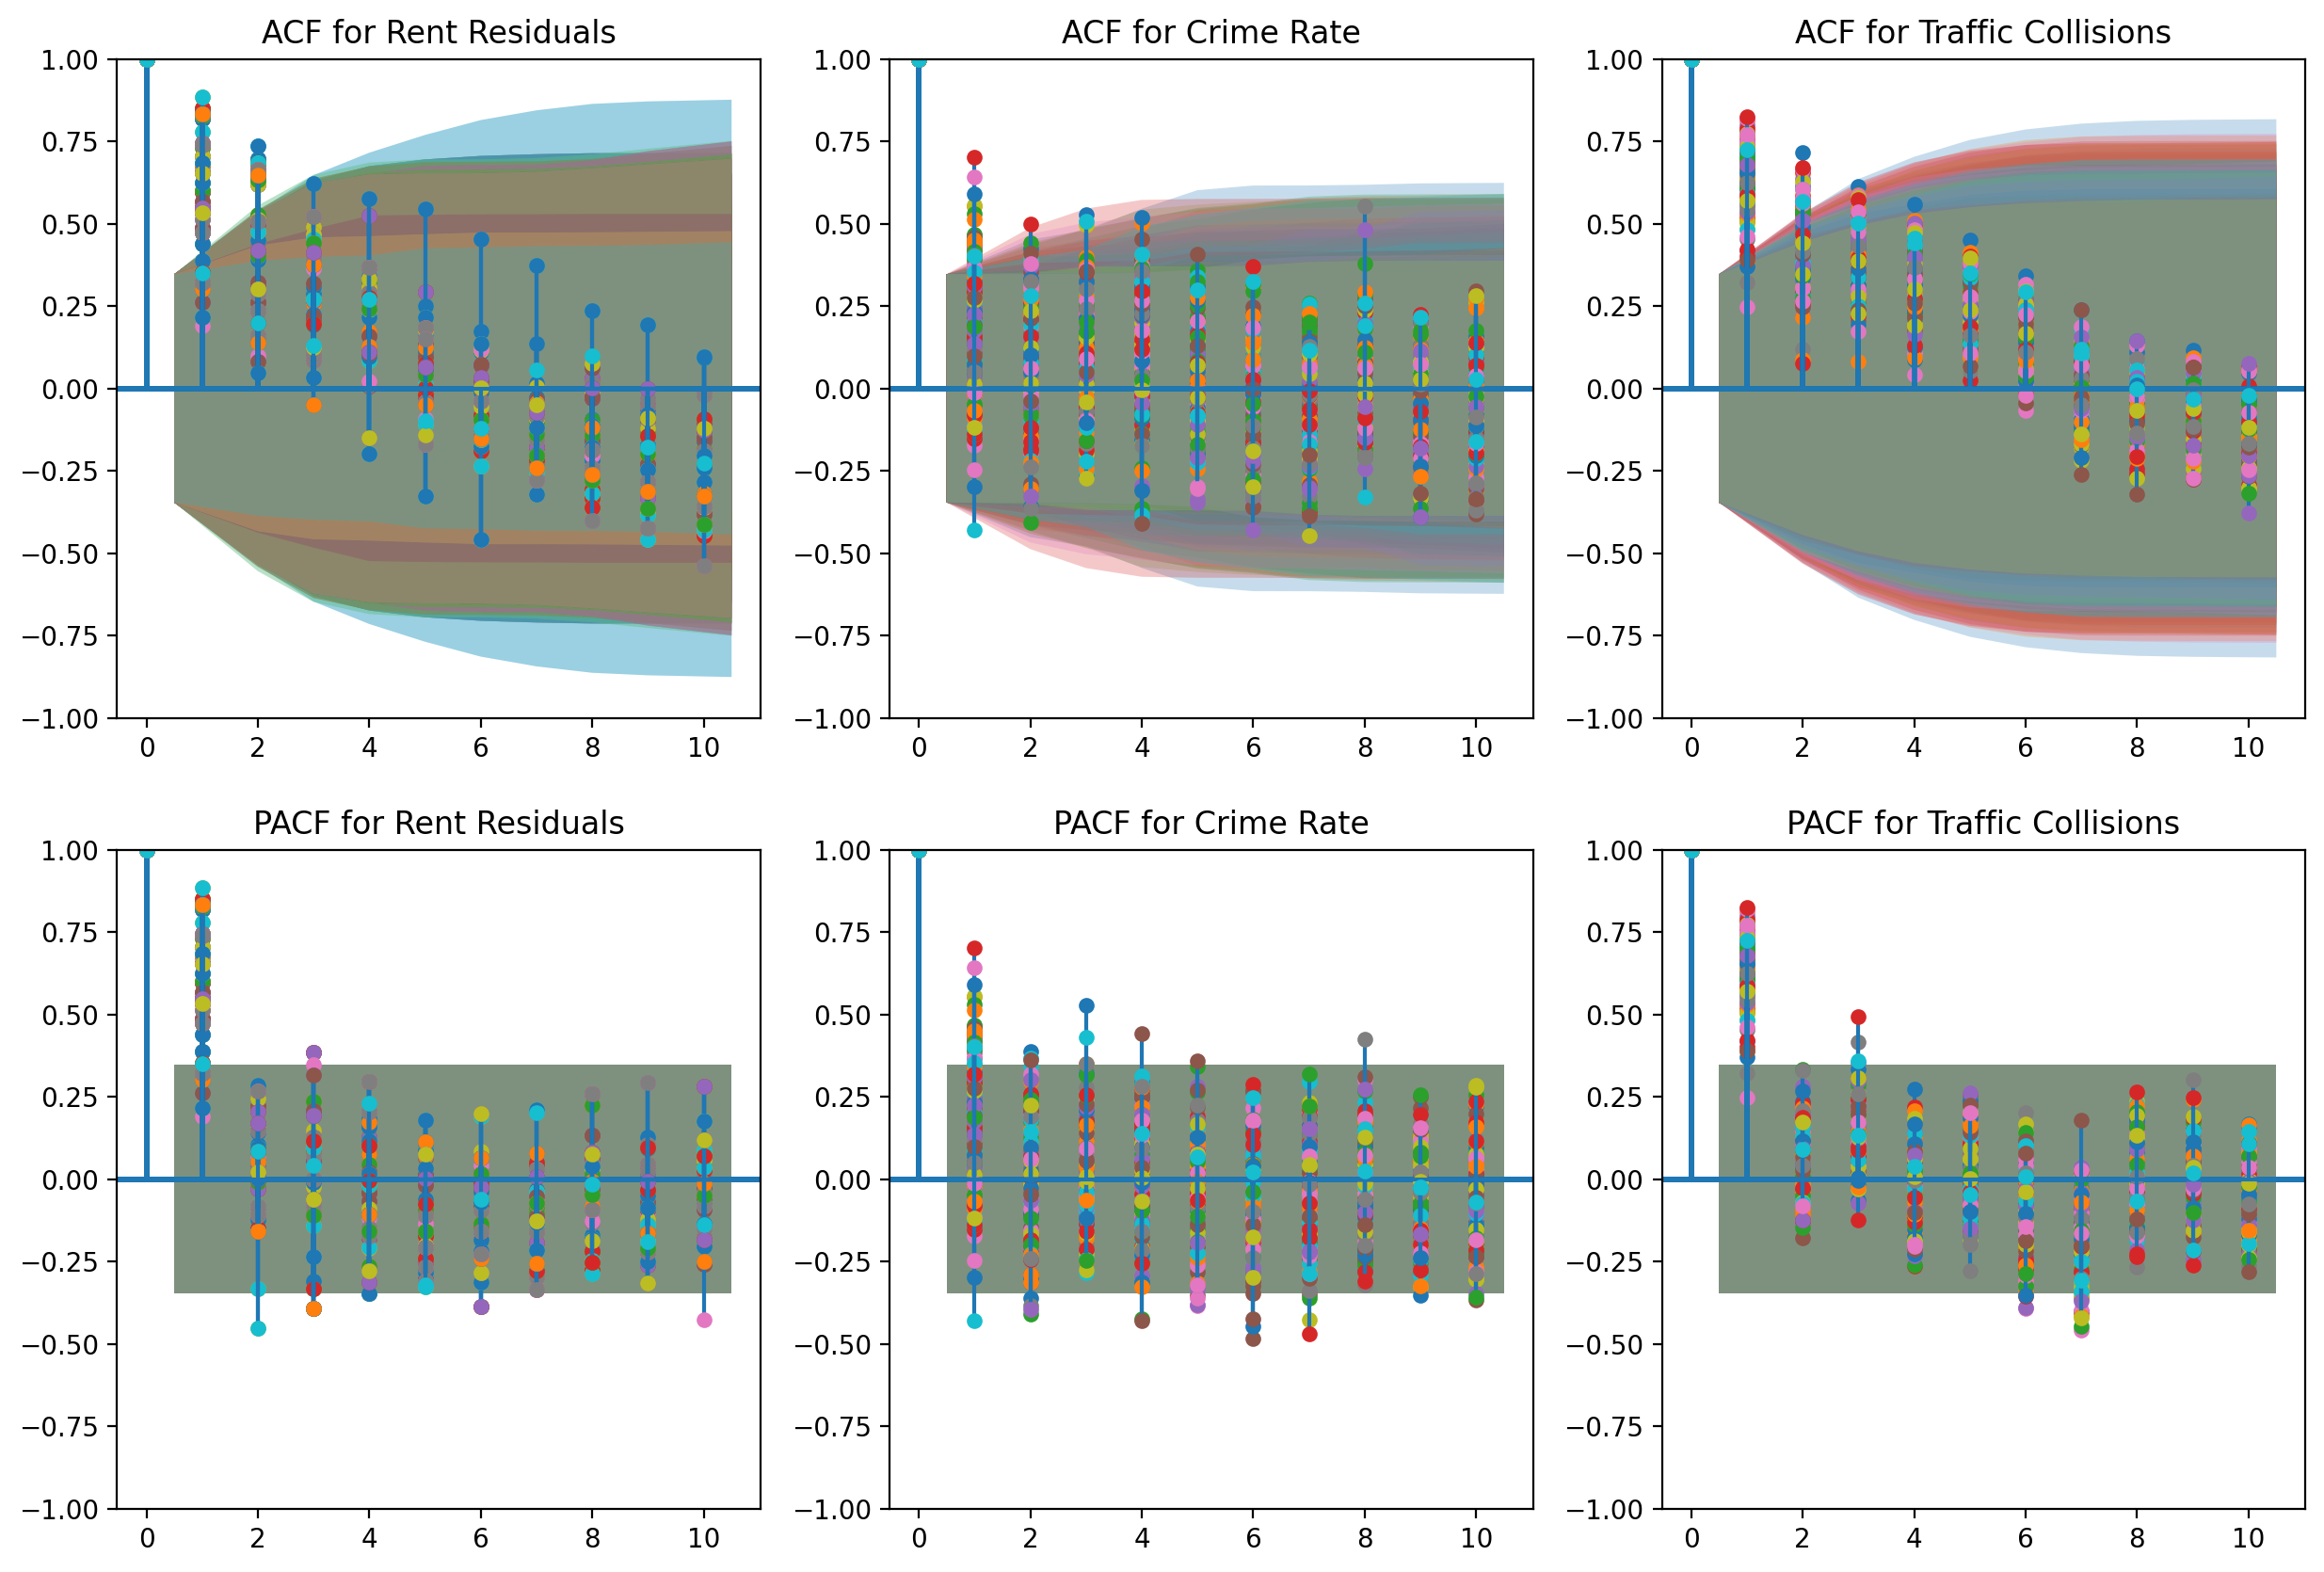

In [37]:
fig, axes = plt.subplots(2, 3)
lag = 10
for hood in tseries_df.hood_id.unique():    
    _ = tsaplots.plot_acf(tseries_df.Rent_Resid[tseries_df.hood_id == hood], lags = lag, ax = axes[0,0], title = 'ACF for Rent Residuals')
    _ = tsaplots.plot_pacf(tseries_df.Rent_Resid[tseries_df.hood_id == hood], lags = lag, ax = axes[1,0], method = 'ywm', title = 'PACF for Rent Residuals')
    _ = tsaplots.plot_acf(tseries_df.Crime[tseries_df.hood_id == hood], lags = lag, ax = axes[0,1], title = 'ACF for Crime Rate')
    _ = tsaplots.plot_pacf(tseries_df.Crime[tseries_df.hood_id == hood], lags = lag, ax = axes[1,1], method = 'ywm', title = 'PACF for Crime Rate')
    _ = tsaplots.plot_acf(tseries_df.Traffic_Collisions[tseries_df.hood_id == hood], lags = lag, ax = axes[0,2], title = 'ACF for Traffic Collisions')
    _ = tsaplots.plot_pacf(tseries_df.Traffic_Collisions[tseries_df.hood_id == hood], lags = lag, ax = axes[1,2], method = 'ywm', title = 'PACF for Traffic Collisions')

## Panel auto ARMA 

In [38]:
def panel_autoARMA(column, max_p = 3, max_q = 3):
    ar_choice = []
    ma_choice = []
    bic_choice = []
    warnings.simplefilter('ignore')
    
    with tqdm(total = (max_p * max_q)) as pbar:
        for ar in range(max_p + 1):
            for ma in range(max_q + 1):
                ar_choice.append(ar)
                ma_choice.append(ma)
                bic_list = []
                for hood in tseries_df.hood_id.unique():    
                    try:
                        model = ARIMA(tseries_df[column][tseries_df.hood_id == hood], order = (ar, 0, ma)).fit()
                        bic_list.append(model.bic)
                    except:
                        bic_list.append(np.nan)
                bic_choice.append(bic_list)
                pbar.update(1)
    return pd.DataFrame({'AR': ar_choice, 
                         'MA': ma_choice, 
                         'BIC_5th': [np.nanquantile(x,0.05) for x in bic_choice],
                         'BIC_25th': [np.nanquantile(x,0.25) for x in bic_choice],
                         'BIC_avg': [np.nanmean(x) for x in bic_choice],
                         'BIC_75th': [np.nanquantile(x,0.75) for x in bic_choice],
                         'BIC_95th': [np.nanquantile(x,0.95) for x in bic_choice]})

In [39]:
resid_arma = panel_autoARMA('Rent_Resid')
crime_arma = panel_autoARMA('Crime')
traffic_arma = panel_autoARMA('Traffic_Collisions')

16it [04:36, 17.29s/it]                      
16it [03:37, 13.60s/it]                      
16it [04:16, 16.00s/it]                      


In [40]:
def plot_BIC(BIC_df, ax = None, title = ""):
    columns = ['BIC_5th', 'BIC_25th', 'BIC_avg', 'BIC_75th', 'BIC_95th']
    if ax is None:
        ax = BIC_df[columns].plot()
    else:
        BIC_df[columns].plot(ax = ax)
    suggestion_90pct = BIC_df[['BIC_5th', 'BIC_95th']].sum(axis=1).idxmin()
    ax.set_title(title + f" / Suggested ARMA: ({BIC_df['AR'][suggestion_90pct]}, {BIC_df['MA'][suggestion_90pct]})")
    ax.set_ylabel('BIC')
    ax.set_xlabel('ARMA (p,q)')
    ax.set_xticks(BIC_df.index)
    ax.set_xticklabels([','.join([str(x),str(y)]) for x, y in zip(BIC_df.AR, BIC_df.MA)])
    return ax

<AxesSubplot:title={'center':'Traffic Collisions / Suggested ARMA: (1, 0)'}, xlabel='ARMA (p,q)', ylabel='BIC'>

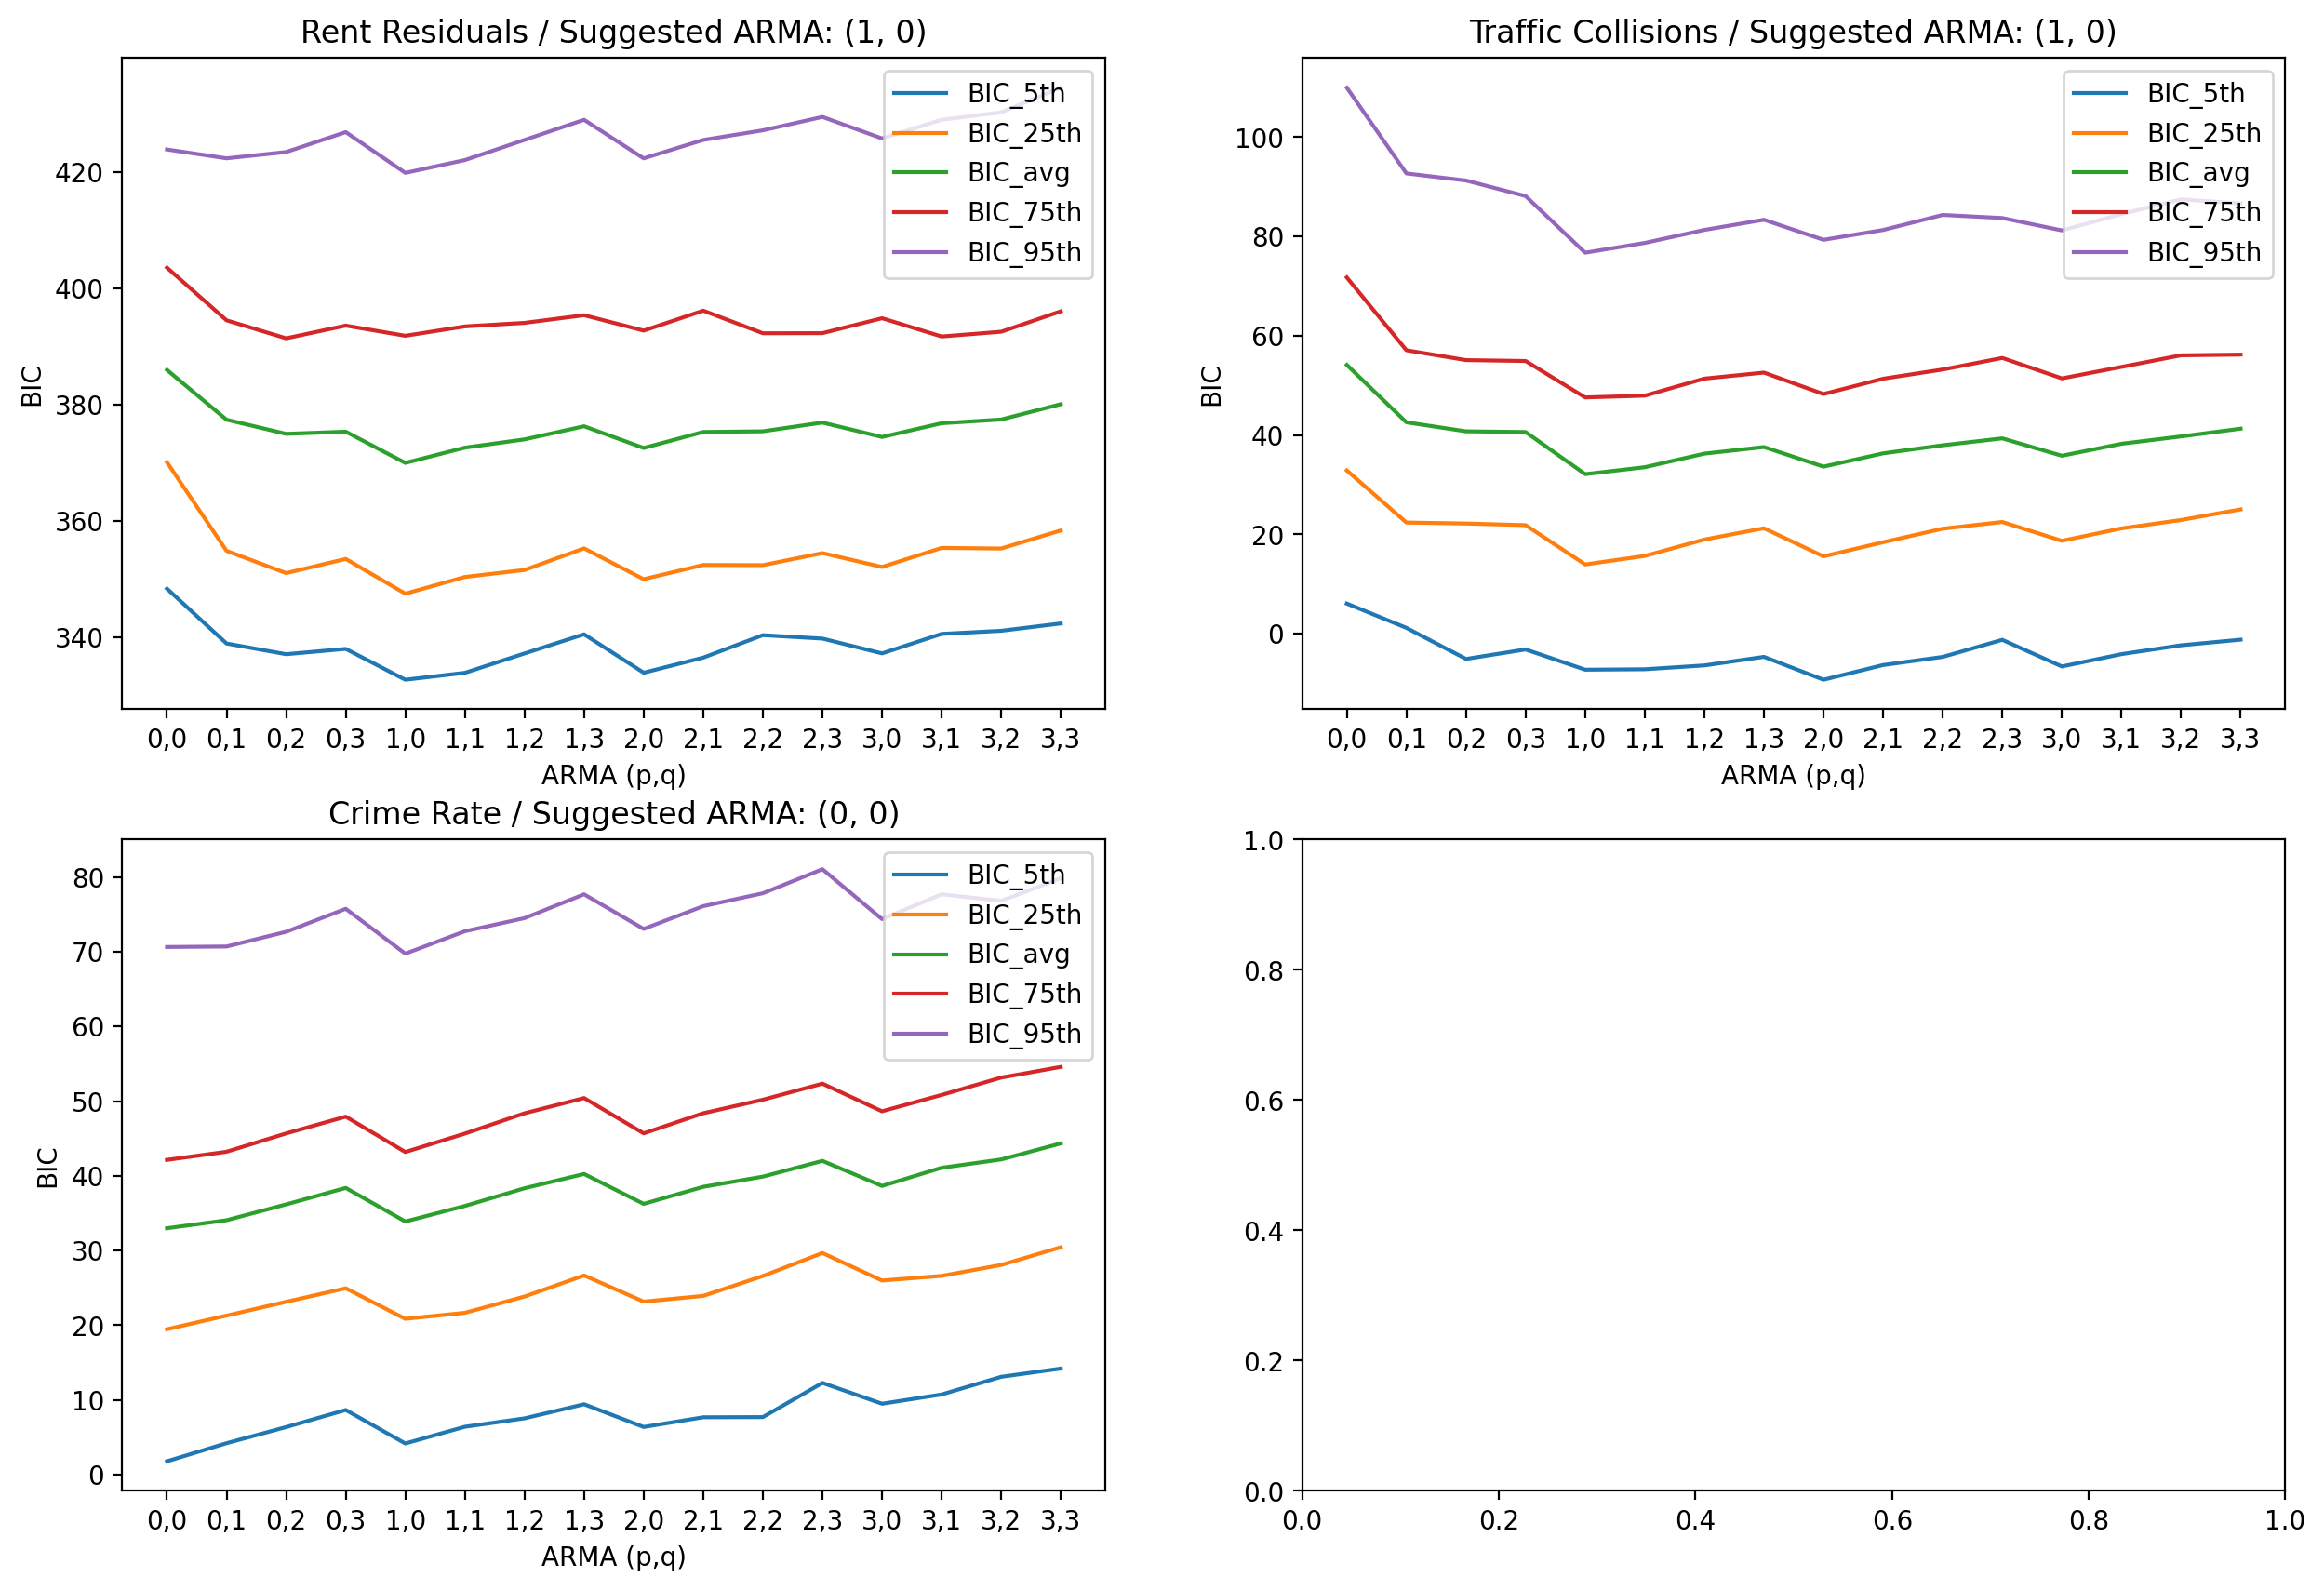

In [41]:
fig, axes = plt.subplots(2, 2)
plot_BIC(resid_arma, axes[0,0], 'Rent Residuals')
plot_BIC(crime_arma, axes[1,0], 'Crime Rate')
plot_BIC(traffic_arma, axes[0,1], 'Traffic Collisions')

## Out-sample forecast

In [42]:
def arma_predict(hood, ar, ma, column):
    return ARIMA(tseries_df[column][tseries_df.hood_id == hood], order = (ar, 0, ma)).fit().forecast()[0]

In [53]:
# 1-step forecast
pred_df = pd.DataFrame({'hood_id': tseries_df.hood_id.unique(),
                        'Time': (tseries_df.index.max() + 1).year + (tseries_df.index.max() + 1).quarter / 4, 
                        'Rent_Resid': [arma_predict(x, 1, 0, 'Rent_Resid') for x in tseries_df.hood_id.unique()],
                        'Crime': [arma_predict(x, 0, 0, 'Crime') for x in tseries_df.hood_id.unique()],
                        'Traffic_Collisions': [arma_predict(x, 1, 0, 'Traffic_Collisions') for x in tseries_df.hood_id.unique()]})

In [54]:
pred_df

hood_id     Time  Rent_Resid     Crime  Traffic_Collisions
0         1  2022.25   -2.463440  2.259829           -1.170695
1         2  2022.25   -2.463440  0.075666           -1.384658
2         3  2022.25   -2.463440 -0.036213           -1.073590
3         4  2022.25   -2.463440  0.152784           -1.167809
4         5  2022.25   -2.463440 -0.071233           -1.135620
..      ...      ...         ...       ...                 ...
135      94  2022.25   16.872741 -0.427737           -1.204239
136      95  2022.25   16.872742  0.722442           -1.368402
137      96  2022.25   16.872743 -0.587025           -0.965738
138      97  2022.25   16.872743 -1.008334           -1.054499
139      98  2022.25   32.308690 -0.053201           -1.300006

[140 rows x 5 columns]

In [56]:
output = pd.DataFrame({
    'hood_id': pred_df.hood_id,
    'Time': pred_df.Time,
    'AvgLeaseRatePerRoom': best_subset.predict({'hood_id': pred_df.hood_id, 'Time': pred_df.Time}),
    'MCI_rate': pred_df['Crime'] * regression_table['MCI_rate'].std() + regression_table['MCI_rate'].mean(),
    'collision_rate': pred_df['Traffic_Collisions'] * regression_table['collision_rate'].std() + regression_table['collision_rate'].mean()
})

output

hood_id     Time  AvgLeaseRatePerRoom    MCI_rate  collision_rate
0         1  2022.25          1080.846546  653.641535       92.766383
1         2  2022.25          1080.846546  300.778257       27.475433
2         3  2022.25          1080.846546  282.703673      122.398271
3         4  2022.25          1080.846546  313.237128       93.647144
4         5  2022.25          1080.846546  277.045968      103.469561
..      ...      ...                  ...         ...             ...
135      94  2022.25          2315.317436  219.450901       82.530431
136      95  2022.25          2315.317436  405.268419       32.436117
137      96  2022.25          2315.317436  193.717132      155.309227
138      97  2022.25          2315.317436  125.652372      128.223650
139      98  2022.25          1811.709214  279.959105       53.307244

[140 rows x 5 columns]

In [59]:
output.to_csv('../data/processed/neighbourhoods_prediction.csv', index = False)

# Difference among neighbourhoods?
- if there is no difference, we can model the average lease rate as a single time series
- otherwise we need to model each neighbourhood separately

In [ ]:
# Instead of performing an ANOVA to see if we can assume all neighbourhoods share the same average lease rate,
# We can perform an F test for the regression of Rent against dummy variables representing each neighbourhoods
# if at least one of the params is different from 0, we can reject the null hypothesis that all neighbourhoods share the same average rent
# the F statistic here is large enough for us to reject the null
sm.OLS(regression_df[Y], sm.add_constant(pd.get_dummies(regression_table['hood_id']))).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rent   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     66.27
Date:                Sat, 07 May 2022   Prob (F-statistic):               0.00
Time:                        17:53:35   Log-Likelihood:                -29814.
No. Observations:                4480   AIC:                         5.991e+04
Df Residuals:                    4340   BIC:                         6.081e+04
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1353.3555      2.832    477.828      0.000    1347.803    1358.908
1           -225.9532     33.631     -6.719      0.000    -291.887    -160.019
10            12.0098     33.631      0.357      0.721     -53.924      77.944
100          196.3178     33.631      5.837      0.000     130.384     262.252
101          196.3178     33.631      5.837      0.000     130.384     262.252
102          118.4788     33.631      3.523      0.000      52.545     184.413
103          118.4788     33.631      3.523      0.000      52.545     184.413
104          292.2128     33.631      8.689      0.000     226.279     358.147
105          118.4788     33.631      3.523      0.000      52.545     184.413
106          196.3178     33.631      5.837      0.000     130.384     262.252
107          196.3178     33.631      5.837      0.000     130.384     262.252
108         -127.6513     33.631     -3.796      0.000    -193.585     -61.718
109         -267.0796     33.631     -7.941      0.000    -333.013    -201.146
11            12.0098     33.631      0.357      0.721     -53.924      77.944
110         -267.0796     33.631     -7.941      0.000    -333.013    -201.146
111         -267.0796     33.631     -7.941      0.000    -333.013    -201.146
112         -127.6513     33.631     -3.796      0.000    -193.585     -61.718
113         -127.6513     33.631     -3.796      0.000    -193.585     -61.718
114          196.4096     33.631      5.840      0.000     130.476     262.343
115         -127.6513     33.631     -3.796      0.000    -193.585     -61.718
116         -276.8182     33.631     -8.231      0.000    -342.752    -210.884
117         -276.8182     33.631     -8.231      0.000    -342.752    -210.884
118         -276.8182     33.631     -8.231      0.000    -342.752    -210.884
119         -281.3806     33.631     -8.367      0.000    -347.314    -215.447
12            12.0098     33.631      0.357      0.721     -53.924      77.944
120         -281.3806     33.631     -8.367      0.000    -347.314    -215.447
121          -78.1144     33.631     -2.323      0.020    -144.048     -12.181
122          -78.1144     33.631     -2.323      0.020    -144.048     -12.181
123         -378.3139     33.631    -11.249      0.000    -444.248    -312.380
124         -281.3806     33.631     -8.367      0.000    -347.314    -215.447
125         -281.3806     33.631     -8.367      0.000    -347.314    -215.447
126         -281.3806     33.631     -8.367      0.000    -347.314    -215.447
127          -91.3663     33.631     -2.717      0.007    -157.300     -25.432
128         -239.3390     33.631     -7.117      0.000    -305.273    -173.405
129         -239.3390     33.631     -7.117      0.000    -305.273    -173.405
13            12.0098     33.631      0.357      0.721     -53.924      77.944
13

# Improvement
- cross validation https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html#Specifying-the-number-of-forecasts 

# Notes

Assumptions to check
- Multicollinearity
  - Why is it a problem?
    1) Hard to interpret the parameters as the sign can become opposite
    2) Hard to make inferences about the parameters as standard errors can be wrong
    - Check for below signs:
      1) Significant correlations between independent variables
      2) Variance inflation factor (VIF) > 10
- There should be no outliers and influential observations
  - Outliers may represent erroneous data which should be corrected
  - Influential observations are observations far from its mean (i.e. observations with high leverage)
      - They can have a strong impact on the value of parameters estimated, rendering any t test or F test useless in measuing model's performance
  - Cook's distance measures both leverage and residual of each observation
      -  Cook's distance > 1 indicates an influential observation that can severly impact the regression results

Residual diagnostics
- To conduct hypothesis testing of regression coefficients and form prediction intervals of future values of y, we must satisfy the following assumptions:
- (1) ε is normally distributed,
- (2) with a mean of 0, 
- (3) the variance σ^2 is constant, and 
- (4) all pairs of error terms are uncorrelated

<img src='../data/image/2022-05-08-00-44-27.png'>
<img src='../data/image/2022-05-08-00-45-04.png'>

In [ ]:
# np.random.seed(123)
# calculating many bootstrap replicates
# def draw_bs_reps(df, size=10**4):
#     """Draw bootstrap replicates of linear regression."""

#     # Initialize array of replicates: bs_replicates
#     # bs_replicates = None
#     bs_replicates_intercept = np.empty(size)
#     bs_replicates_slope1 = np.empty(size)
#     bs_replicates_slope2 = np.empty(size)
#     # Generate replicates
#     for i in range(size):
#         inds = np.arange(df.shape[0])
#         # generate a list of indices with replcaement with the same size as our original dataframe
#         # to ensure the distribution of bootstrap replicates is the same as that of our estimated coefficients
#         bs_inds = np.random.choice(inds, size = len(inds), replace = True)
#         # pairwise bootstrapping on Y and Xs
#         bootstrap_df = df.iloc[bs_inds]
#         X_df = bootstrap_df[[*best_subsets]]
#         X_df.insert(0, 'Intercept', 1)
#         # use (Moore-Penrose) pseudo-inverse to speed up regression since we only need the estimated coefficients
#         bs_replicates_intercept[i], bs_replicates_slope1[i], bs_replicates_slope2[i] = np.linalg.pinv(X_df) @ bootstrap_df[Y]

#     return bs_replicates_intercept, bs_replicates_slope1, bs_replicates_slope2

#### Confidence Intervals
Let's compare the confidence interval of regression coefficients with the following obtained from bootstrapped samples:
  - Normal interval
  - Percentile interval
  - Bias corrected interval

While t tests from regression are significant for all estimated coefficients,
  - Bootstrapping helps verify that 
    - We can be 95% confident that our confidence intervals would contain the true coefficients after adjusting familywise error rate (FWER) with Bonferroni correction to address statistical multiplicity
    - Violation of residual assumptions are not extreme enough to significantly impact our confidence intervals and statistical tests of estimated parameters
  - Since 0 is not within our confidence intervals, all of our estimated coefficients are significant

In [ ]:
# normal, percentile, BC + Lower Bound / Upper Bound
# bonferroni_correction = 2 # number of t tests to be conducted simultaneously
# alpha = 0.05 / bonferroni_correction # 95% confidence interval corrected by Bonferroni correction to address statistical multiplicity
# tails = 2 # two-tailed test
# intervals = None

# for i, (sample_statistic, bs_statistic) in enumerate(zip([slope1, slope2], 
#                                                          [bs_slope1, bs_slope2])):
    
#     # OLS intervals
#     # ols_interval = best_subsets_results.conf_int().iloc[i+1].tolist()
    
#     # normal intervals
#     normal = stats.norm.ppf(alpha/tails)
#     normal_interval = [sample_statistic + normal * np.std(bs_statistic), sample_statistic - normal * np.std(bs_statistic)]
    
#     # percentile intervals
#     percentile = [alpha/tails*100, (1-alpha/tails)*100]
#     percentile_interval = np.percentile(bs_statistic, percentile)
    
#     # Bias corrected intervals (BC)
#     bias_correction = stats.norm.ppf(sum(bs_statistic <= sample_statistic) / len(bs_statistic)) # remove statistical bias due to randomness
#     bc_percentile = [stats.norm.cdf(bias_correction + normal)*100, stats.norm.cdf(bias_correction - normal)*100]
#     bc_interval = np.percentile(bs_statistic, bc_percentile)
    
#     intervals = pd.concat([intervals, pd.DataFrame([normal_interval, percentile_interval, bc_interval])])

# intervals

# intervals_index = pd.MultiIndex.from_arrays([np.repeat([*best_subsets_results.params.index.values[1:]],3).tolist(),
#                                              ['Normal', 'Percentile', 'Bias Corrected']*int(intervals.shape[0]/3)],
#                                             names = ['Coefficients', 'Confidence Intervals'])
# intervals_columns = [f'{(1-alpha*bonferroni_correction)*100:0.0f}% CI Lower Bound', f'{(1-alpha*bonferroni_correction)*100:0.0f}% CI Upper Bound']
# intervals.index = intervals_index
# intervals.columns = intervals_columns
# intervals

95% CI Lower Bound  95% CI Upper Bound
Coefficients Confidence Intervals                                        
Lease_Demand Normal                         12.058286           31.900529
             Percentile                     12.155857           31.979526
             Bias Corrected                 12.158712           31.983661
Distance     Normal                       -196.645175         -178.456662
             Percentile                   -196.612066         -178.503892
             Bias Corrected               -196.606744         -178.501091